## **Problem Statement**


Rossmann is a European drug distributor which operates over 3,000 drug stores across seven European countries. Since a lot of drugs come with a short shelf life, that is, they do not have a long expiry date, it becomes imperative for Rossmann to accurately forecast sales at their individual stores. Currently, the forecasting is taken care of by the store managers who are tasked with forecasting daily sales for the next six weeks.



As expected, store sales are influenced by many factors, including promotional campaigns, competition, state holidays, seasonality, and locality.



With thousands of individual managers predicting sales based on their unique circumstances and intuitions, the accuracy of the forecasts is quite varied. To overcome this problem, the company has hired you as a data scientist to work on the forecasting problem. As part of your job role, you are tasked with building a forecasting model to forecast the daily sales for the next six weeks. To help you with the same, you have been provided with historical sales data for 1,115 Rossmann stores.

## Step 1. Importing all the important libraries

In [ ]:
# Importing important libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")

import statsmodels.api as sm
from pylab import rcParams
rcParams["figure.figsize"] = 18, 14

# Importing stationarity tests

from statsmodels.tsa.stattools import adfuller, kpss

# Importing ACF and PACF plots

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Importing MinMaxScaler()

from sklearn.preprocessing import MinMaxScaler

# Importing MeanSquaredError()

from sklearn.metrics import mean_squared_error

In [ ]:
# Changing settings to see maximum data

pd.set_option("display.max_columns", None)
pd.set_option("display.expand_frame_repr", False)
pd.set_option("max_colwidth", None)

In [3]:
# Importing Models

import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.vector_ar.vecm import select_coint_rank

## Step 2. Reading the Datasets and Initial Understanding

In [5]:
from google.colab import files
import pandas as pd

# Upload files manually
uploaded = files.upload()

# Read the datasets
df_raw_train = pd.read_csv("train.csv")
df_raw_store = pd.read_csv("store.csv")

# Display dataset samples
print(df_raw_train.head())
print(df_raw_store.head())

   Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  SchoolHoliday
0      1          5  2015-07-31   5263        555     1      1            0              1
1      2          5  2015-07-31   6064        625     1      1            0              1
2      3          5  2015-07-31   8314        821     1      1            0              1
3      4          5  2015-07-31  13995       1498     1      1            0              1
4      5          5  2015-07-31   4822        559     1      1            0              1
   Store StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear    PromoInterval
0      1         c          a               1270.0                        9.0                    2008.0       0              NaN              NaN              NaN
1      2         a          a                570.0                       11.0                    2007.0       1             13.0

In [6]:
# Checking the shape of Train Dataset

df_raw_train.shape

(1017209, 9)

In [8]:
# Checking the shape of Store Dataset

df_raw_store.shape

(1115, 10)

In [9]:
# Checking the datatype of the columns in the Store dataset

df_raw_store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [10]:
# Checking the summary of the "Store" dataset

df_raw_store.describe()

Store  CompetitionDistance  CompetitionOpenSinceMonth  CompetitionOpenSinceYear       Promo2  Promo2SinceWeek  Promo2SinceYear
count  1115.00000          1112.000000                 761.000000                761.000000  1115.000000       571.000000       571.000000
mean    558.00000          5404.901079                   7.224704               2008.668857     0.512108        23.595447      2011.763573
std     322.01708          7663.174720                   3.212348                  6.195983     0.500078        14.141984         1.674935
min       1.00000            20.000000                   1.000000               1900.000000     0.000000         1.000000      2009.000000
25%     279.50000           717.500000                   4.000000               2006.000000     0.000000        13.000000      2011.000000
50%     558.00000          2325.000000                   8.000000               2010.000000     1.000000        22.000000      2012.000000
75%     836.50000          6882.500000                  10.000000               2013.000000     1.000000        37.000000      2013.000000
max    1115.00000         75860.000000                  12.000000               2015.000000     1.000000        50.000000      2015.000000

#### *Inference: The columns "CompetitionDistance" and "Promo2SinceWeek" have a significant difference between 75% and maximum value indicating presence of outliers.*

In [11]:
# Checking the summary of the "Train" dataset

df_raw_train.describe()

Store     DayOfWeek         Sales     Customers          Open         Promo  SchoolHoliday
count  1.017209e+06  1.017209e+06  1.017209e+06  1.017209e+06  1.017209e+06  1.017209e+06   1.017209e+06
mean   5.584297e+02  3.998341e+00  5.773819e+03  6.331459e+02  8.301067e-01  3.815145e-01   1.786467e-01
std    3.219087e+02  1.997391e+00  3.849926e+03  4.644117e+02  3.755392e-01  4.857586e-01   3.830564e-01
min    1.000000e+00  1.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   0.000000e+00
25%    2.800000e+02  2.000000e+00  3.727000e+03  4.050000e+02  1.000000e+00  0.000000e+00   0.000000e+00
50%    5.580000e+02  4.000000e+00  5.744000e+03  6.090000e+02  1.000000e+00  0.000000e+00   0.000000e+00
75%    8.380000e+02  6.000000e+00  7.856000e+03  8.370000e+02  1.000000e+00  1.000000e+00   0.000000e+00
max    1.115000e+03  7.000000e+00  4.155100e+04  7.388000e+03  1.000000e+00  1.000000e+00   1.000000e+00

## Step 3: Dataset Cleaning and Dataset Transformation before EDA

In [13]:
# Checking percentage of missing/null values

round(100*(df_raw_store.isnull().sum()/len(df_raw_store)),2)

Store                         0.00
StoreType                     0.00
Assortment                    0.00
CompetitionDistance           0.27
CompetitionOpenSinceMonth    31.75
CompetitionOpenSinceYear     31.75
Promo2                        0.00
Promo2SinceWeek              48.79
Promo2SinceYear              48.79
PromoInterval                48.79
dtype: float64

In [14]:
# Creating a copy for transformations

df_store_transformed = df_raw_store.copy()

In [15]:
df_store_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [16]:
# Replacing "NaN" values for certain columns by 0
# List of Columns to fill "NaN" values with 0

na_to_zero_col_list = ["Promo2SinceWeek", "Promo2SinceYear", "PromoInterval", "CompetitionDistance"]

# Fill columns having "NaN" values with 0

df_store_transformed[na_to_zero_col_list] = df_store_transformed[na_to_zero_col_list].fillna(0)

In [17]:
# Replacing "NaN" values for certain columns by Mode()

na_to_mode_col_list = ["CompetitionOpenSinceMonth", "CompetitionOpenSinceYear"]

# Fill columns having "NaN" values with Mode()

df_store_transformed[na_to_mode_col_list] = df_store_transformed[na_to_mode_col_list].apply(lambda x: x.fillna(x.mode().iloc[0]))

In [18]:
df_store_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1115 non-null   float64
 4   CompetitionOpenSinceMonth  1115 non-null   float64
 5   CompetitionOpenSinceYear   1115 non-null   float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            1115 non-null   float64
 8   Promo2SinceYear            1115 non-null   float64
 9   PromoInterval              1115 non-null   object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [19]:
# Checking records where "CompetitionDistance" = 0

df_store_transformed[df_store_transformed["CompetitionDistance"]==0]

Store StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear    PromoInterval
290    291         d          a                  0.0                        9.0                    2013.0       0              0.0              0.0                0
621    622         a          c                  0.0                        9.0                    2013.0       0              0.0              0.0                0
878    879         d          a                  0.0                        9.0                    2013.0       1              5.0           2013.0  Feb,May,Aug,Nov

In [20]:
# Data Discrepancy: If "CompetitionDistance" = 0, it means that there is no competition.
# Hence, the corresponding values of "CompetitionOpenSinceMonth" and "CompetitionOpenSinceYear" should be zero as well.

df_store_transformed.loc[df_store_transformed.CompetitionDistance == 0, "CompetitionOpenSinceMonth"] = 0
df_store_transformed.loc[df_store_transformed.CompetitionDistance == 0, "CompetitionOpenSinceYear"] = 0

In [21]:
# Checking records where "CompetitionDistance" = 0
# Data discrepancies have ben fixed

df_store_transformed[df_store_transformed["CompetitionDistance"]==0]

Store StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear    PromoInterval
290    291         d          a                  0.0                        0.0                       0.0       0              0.0              0.0                0
621    622         a          c                  0.0                        0.0                       0.0       0              0.0              0.0                0
878    879         d          a                  0.0                        0.0                       0.0       1              5.0           2013.0  Feb,May,Aug,Nov

In [22]:
# Checking percentage of missing/null values

round(100*(df_store_transformed.isnull().sum()/len(df_store_transformed)),2)

Store                        0.0
StoreType                    0.0
Assortment                   0.0
CompetitionDistance          0.0
CompetitionOpenSinceMonth    0.0
CompetitionOpenSinceYear     0.0
Promo2                       0.0
Promo2SinceWeek              0.0
Promo2SinceYear              0.0
PromoInterval                0.0
dtype: float64

#### *Inference: Null values have been handled successfully!*

## Step 4: Data Visualization and EDA

### (i) Univariate Analysis

In [23]:
# Creating a UDF for showing the "Countplot()" of the "Categorical Columns"

def countplot_categ_cols(features, df):

    tick_to_ignore = ["CompetitionOpenSinceMonth", "CompetitionOpenSinceYear", "Promo2SinceWeek"]
    num_features = len(features)
    cols = 2
    rows = (num_features + cols - 1) // cols

    plt.figure(figsize=(16, rows * 5))

    for i, feature in enumerate(features, start=1):
        plt.subplot(rows, cols, i)
        ax = sns.countplot(x=feature, data=df, order=df[feature].value_counts().index)
        plt.xticks(rotation=90)
        plt.title("Counts for {}".format(feature))

        if feature not in tick_to_ignore:
            for p in ax.patches:
                ax.text(p.get_x() + p.get_width() / 2., p.get_height() + 3, "{:.2f}%".format(p.get_height() / len(df) * 100), ha="center")

    plt.tight_layout(pad=5, w_pad=5)
    plt.show()


In [24]:
# Selecting the "Categorical Columns" from the "Store" dataset

categ_cols_store = ["StoreType","Assortment","CompetitionOpenSinceMonth","CompetitionOpenSinceYear","Promo2",
                    "Promo2SinceWeek","Promo2SinceYear","PromoInterval"]

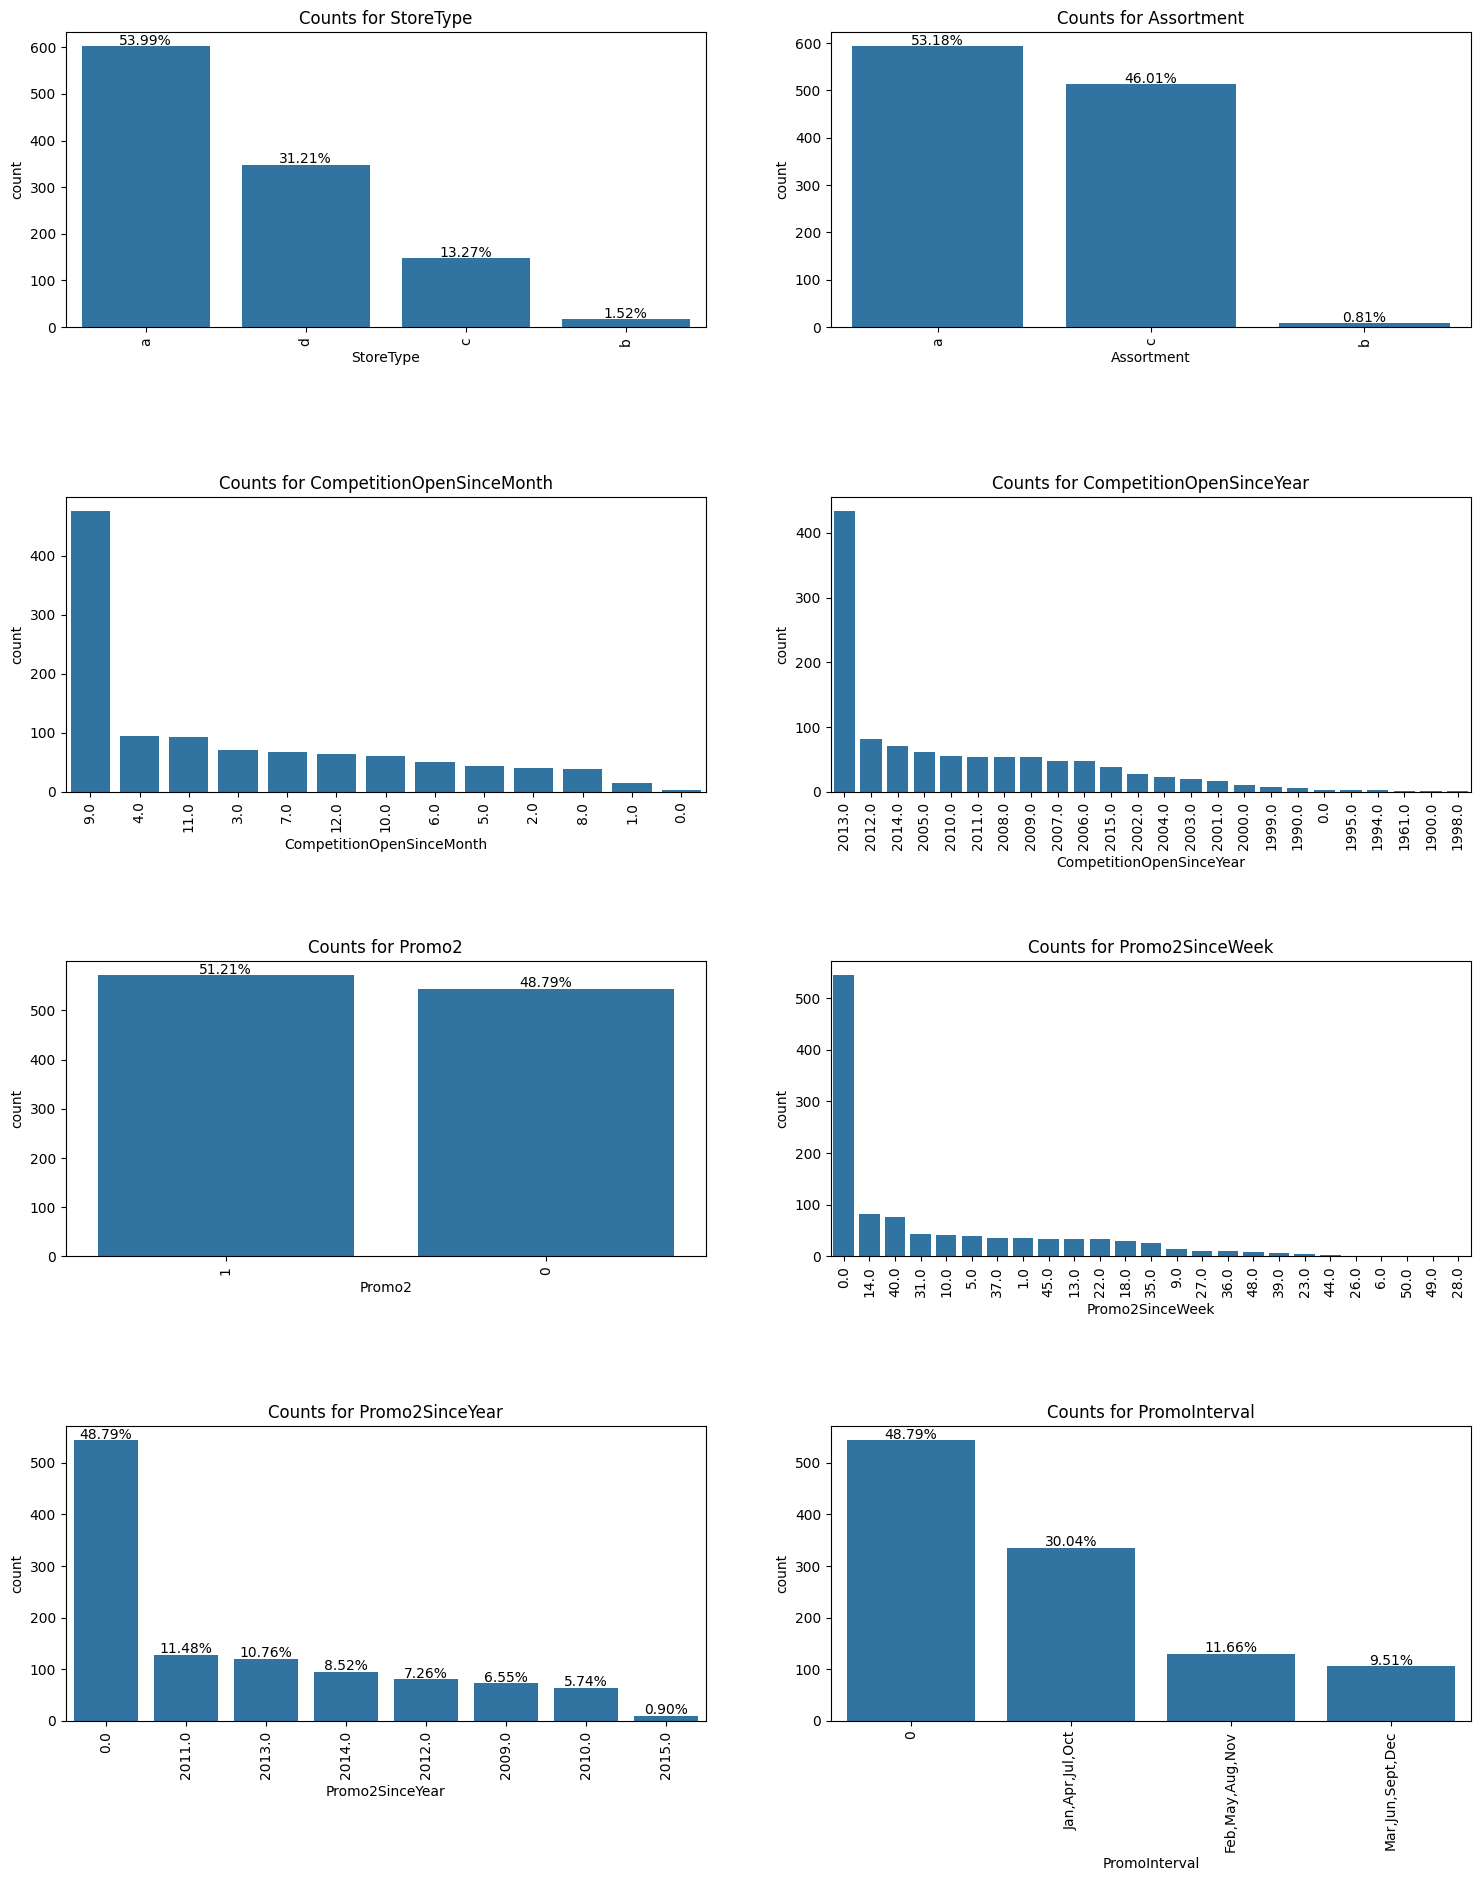

In [25]:
# Countplots for "Categorical Columns" of "Store" dataset

countplot_categ_cols(categ_cols_store, df_store_transformed)

#### Inferences from the graphs of "Store" dataset:

- Majority of the stores(54%) are of type "A"
    
- Most stores primarily offer type A assortments (53%), with other types being less common

- Majority of the competitive stores opened in 2013

- Maximum number of competitve stores opened in the month of September
    
- Nearly 48% of the stores didn"t participate "in "Promo2" promotions

In [26]:
# Selecting the "Categorical Columns" from the "Train" dataset

categ_cols_train = ["DayOfWeek","Open", "Promo", "StateHoliday", "SchoolHoliday"]

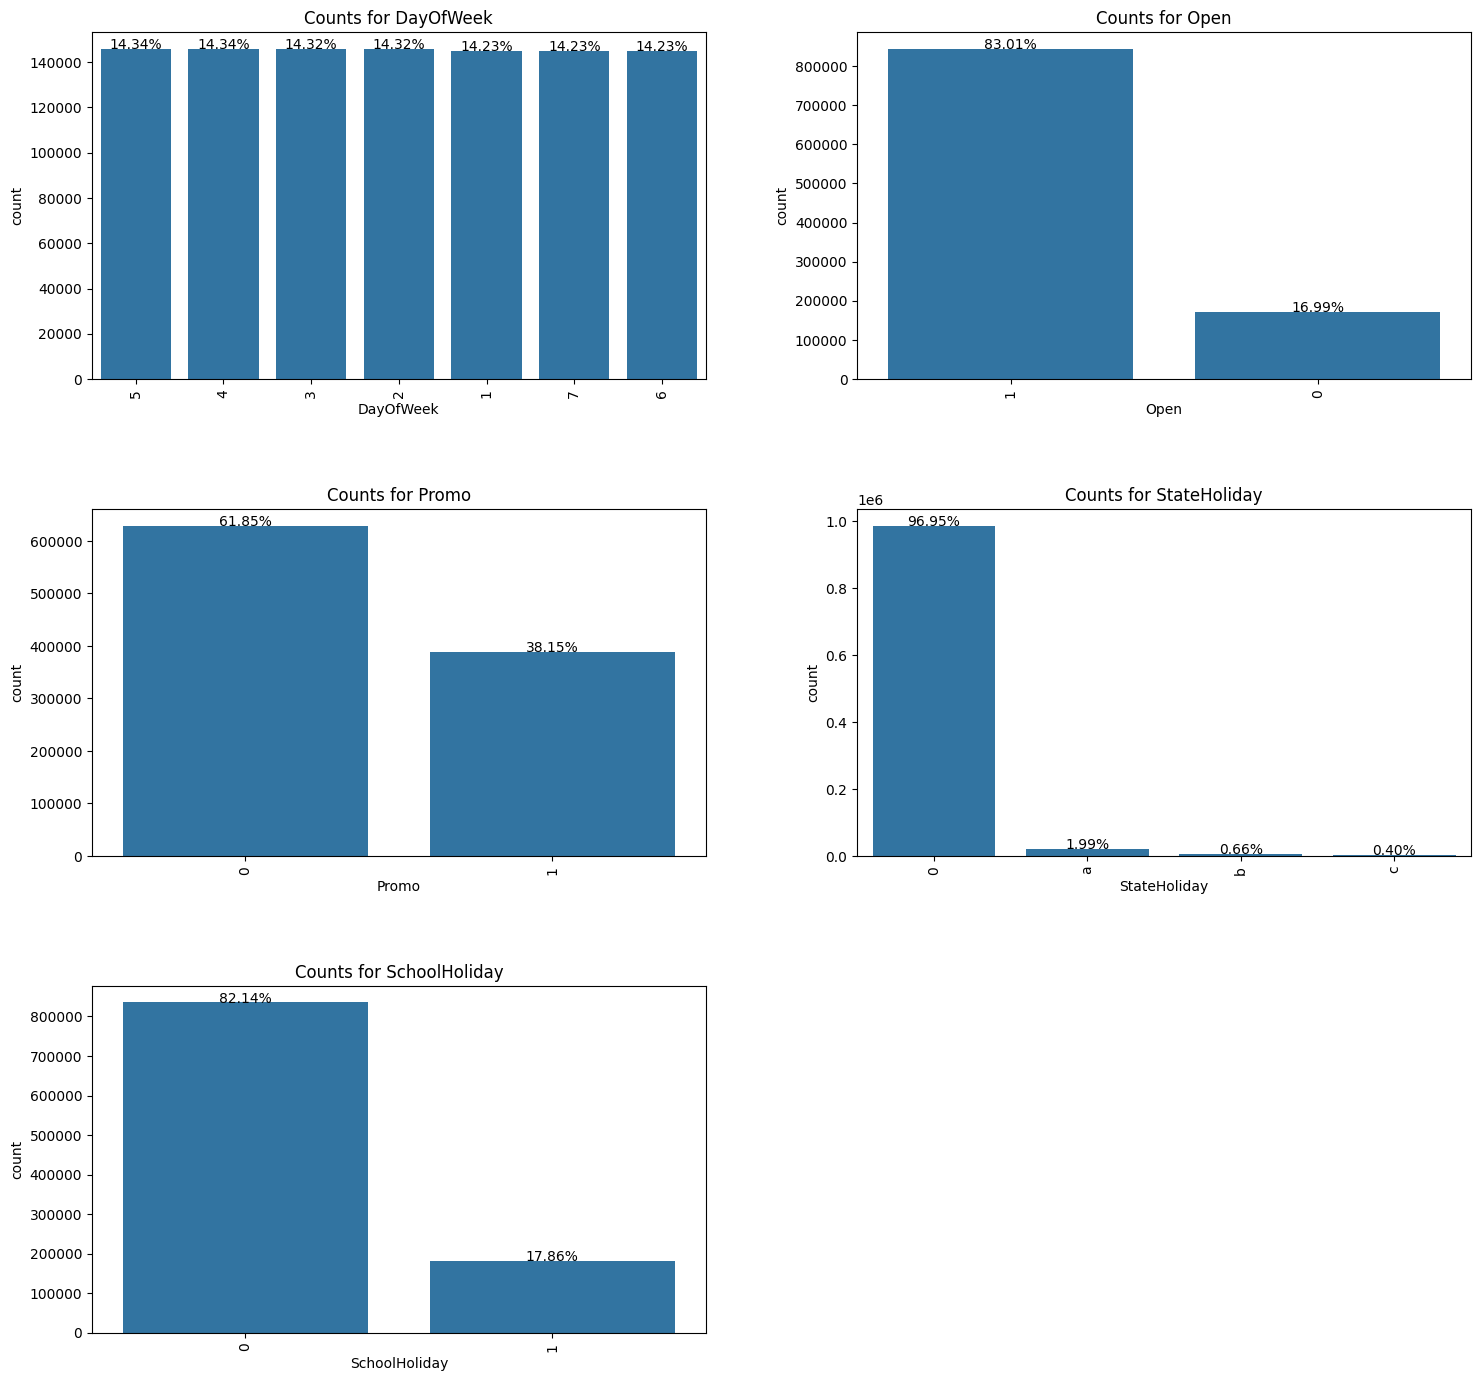

In [27]:
# Countplots for "Categorical Columns" of "Train" dataset

countplot_categ_cols(categ_cols_train, df_raw_train)

#### Inferences from the graphs of "Train" dataset:

- Sales of a store throughout the week are evenly distributed across all days
    
- Store closures are represented in just 17% of the records

- Active promotions are present in 38% of the records

- 18% of records indicate that the store was affected becauseof "School Holiday"

#### *Callout: We will exclusively examine entries where the store is "open", considering that when the store is closed, sales are naturally zero.*

In [28]:
# Filtering for "Open" stores of the "Train" dataset

df_train_open = df_raw_train[df_raw_train["Open"] == 1]

In [29]:
df_train_open.shape

(844392, 9)

### Outlier Detection and Treatment of Outliers

#### (a) Handling outliers for "Store" dataset

In [30]:
# Creating a UDF for plotting the boxplots of a dataset

def plot_boxplots(data, columns):
    num_plots = len(columns)
    cols = 2
    rows = (num_plots + cols - 1) // cols

    plt.figure(figsize=(20, 12))

    for i, column in enumerate(columns, start=1):
        plt.subplot(rows, cols, i)
        sns.boxplot(x=column, data=data)

    plt.show()

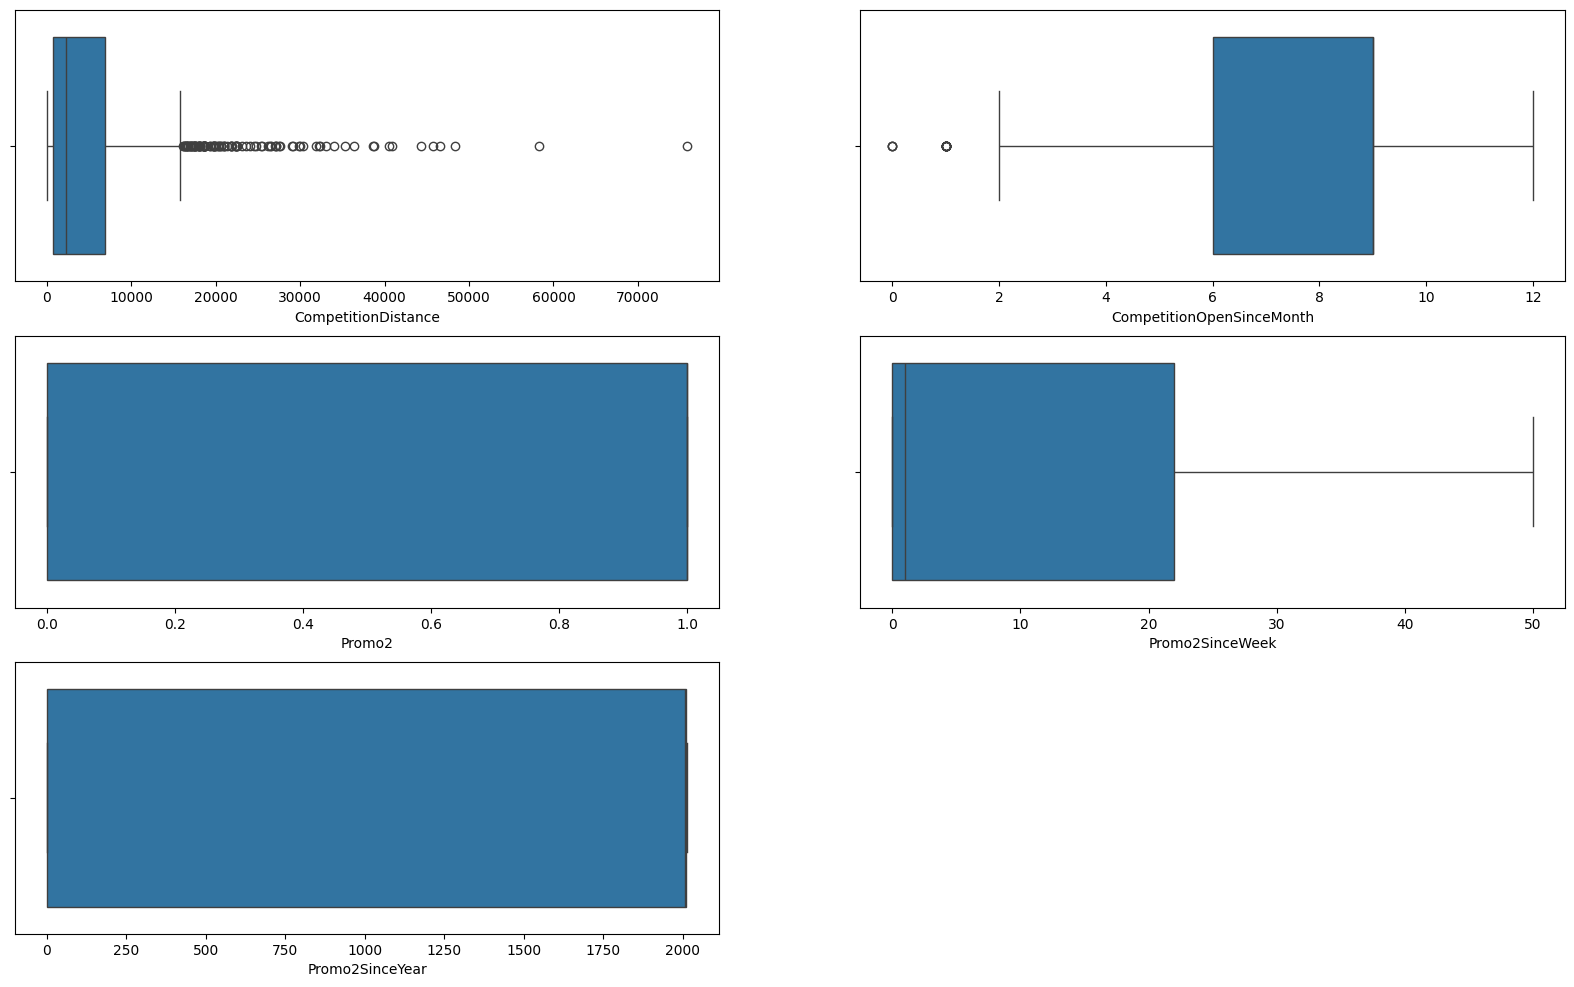

In [31]:
# Boxlots for "Store" dataset

store_boxplot_cols = ["CompetitionDistance", "CompetitionOpenSinceMonth", "Promo2", "Promo2SinceWeek", "Promo2SinceYear"]

plot_boxplots(df_store_transformed, store_boxplot_cols)

#### *Inference: For "CompetitionDistance", values beyond the 99th percentile are unnecessary. We can set a cap on values exceeding the 99th percentile, limiting them to that percentile in order to manage the "CompetitionDistance" variable.*

In [32]:
# Capping the values of "CompetitionDistance" to 99th percentile

df_store_transformed.loc[df_store_transformed.CompetitionDistance>df_store_transformed.CompetitionDistance.quantile(.99),"CompetitionDistance"]=df_store_transformed.CompetitionDistance.quantile(.99)

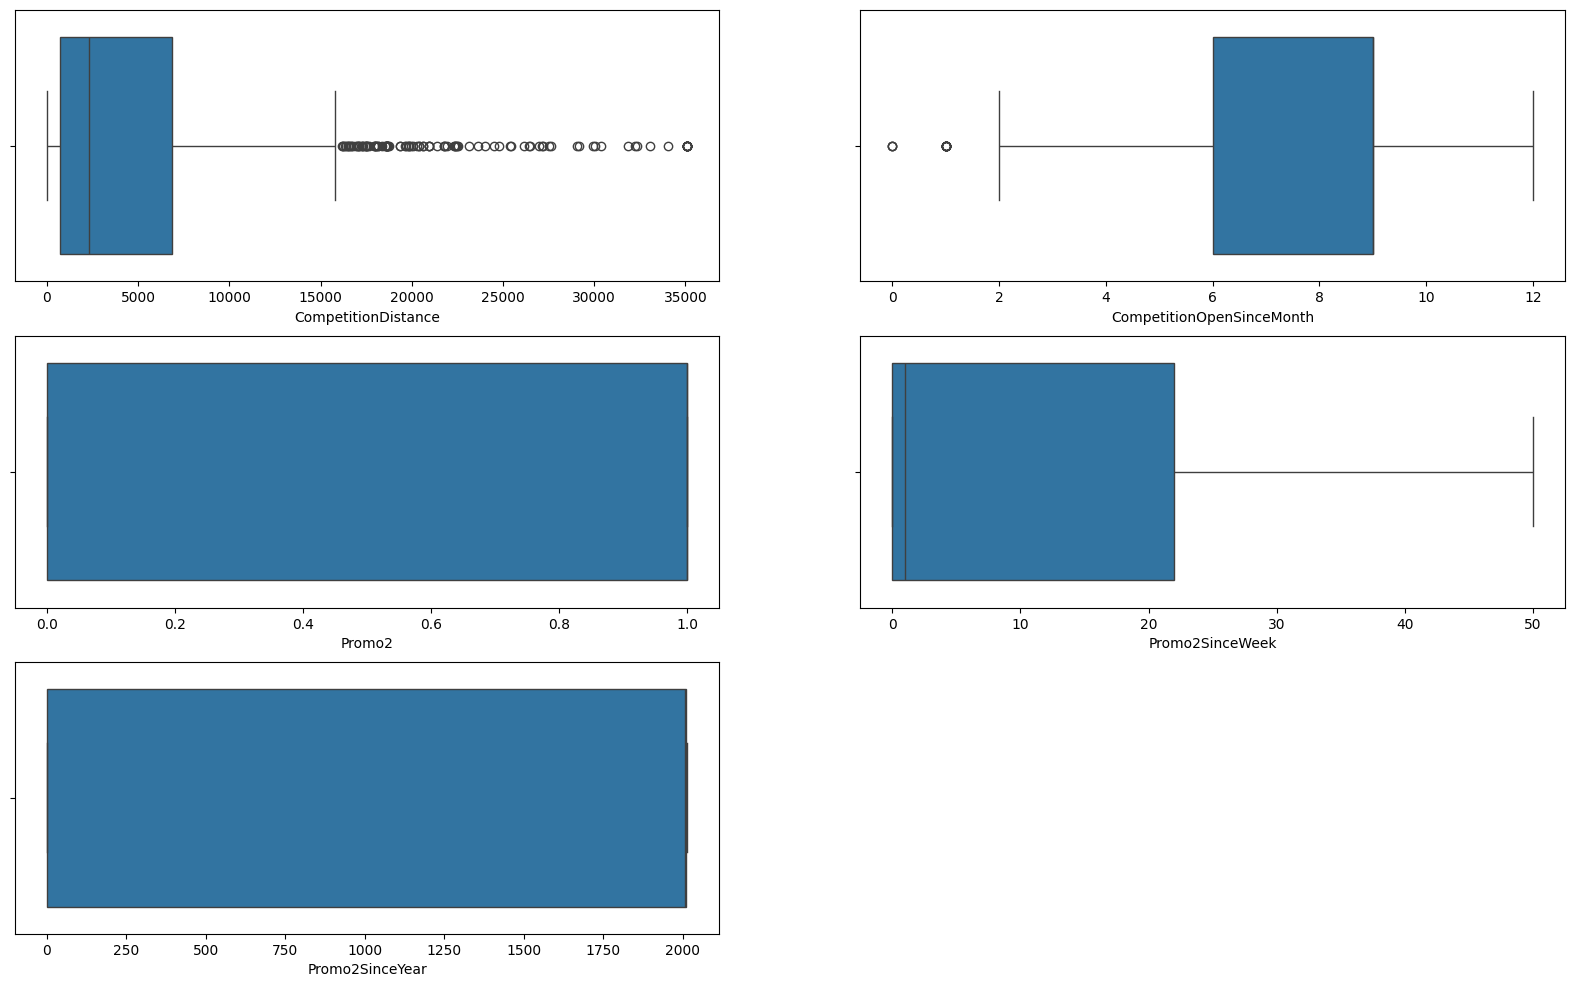

In [33]:
# Checking the Boxlots for "Store" dataset again after capping the values at 99th percentile

plot_boxplots(df_store_transformed, store_boxplot_cols)

#### *Inference: Outliers for "Store" dataset have been treated.*

#### (b) Handling outliers for "Train" dataset

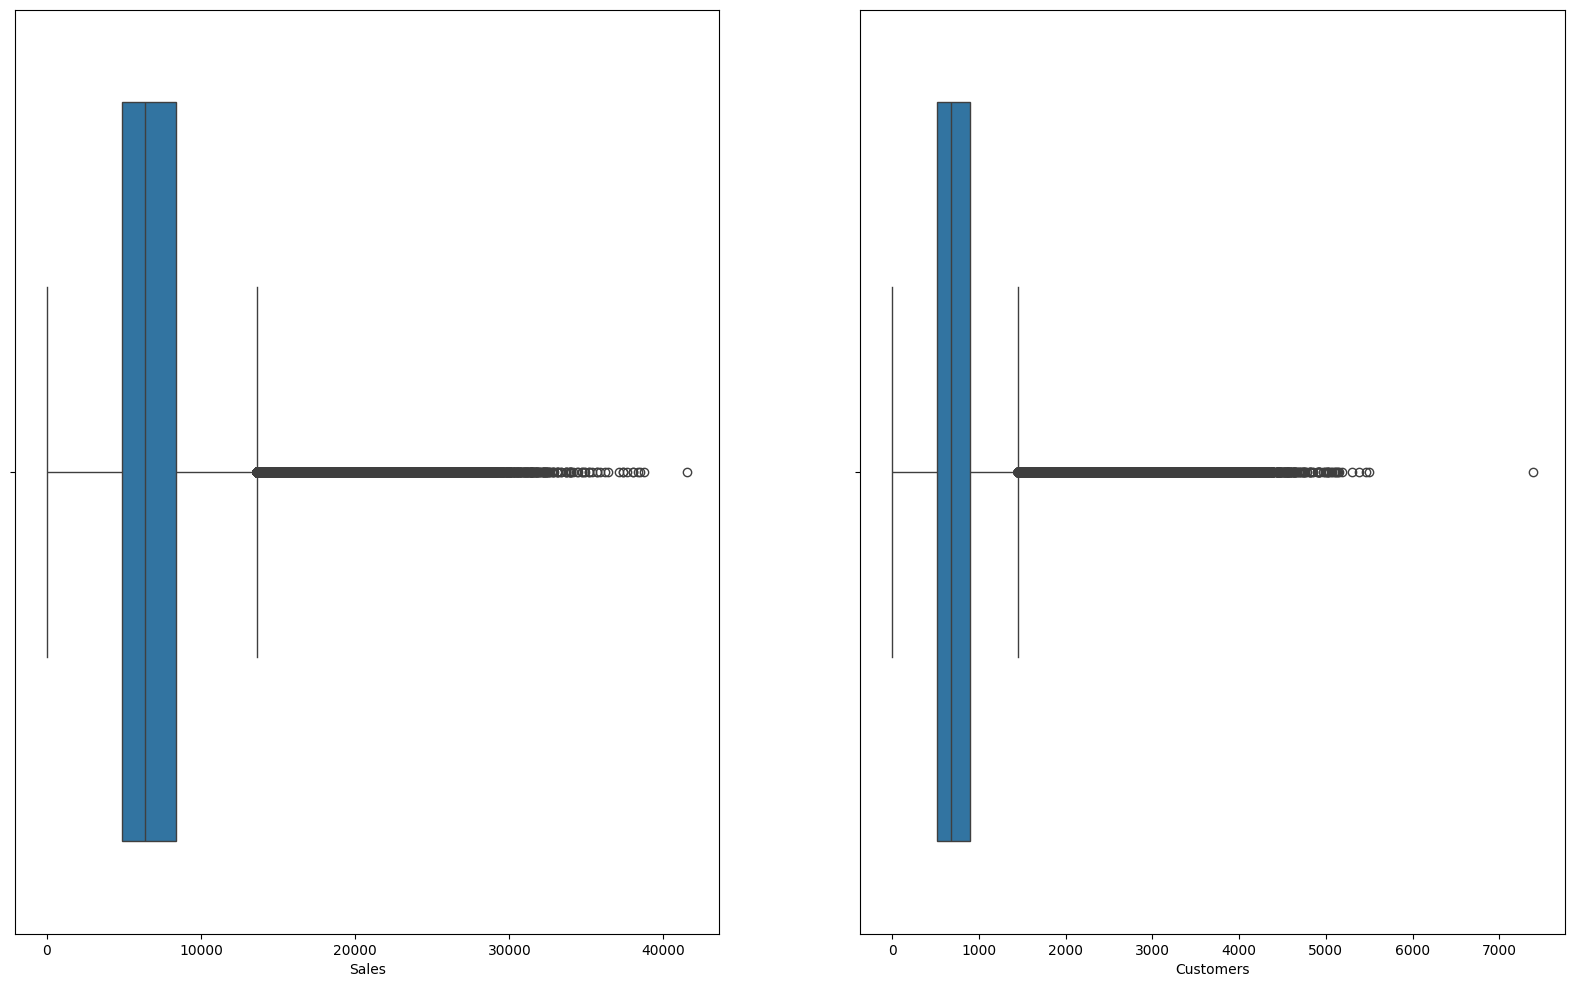

In [34]:
# Boxlots for "Train" dataset

train_boxplot_cols = ["Sales", "Customers"]

plot_boxplots(df_train_open, train_boxplot_cols)

In [35]:
# Detecting outliers at 90, 95 and 99 percentile

df_train_open.describe(percentiles=[0.90,0.95,0.99]).round(2)

Store  DayOfWeek      Sales  Customers      Open      Promo  SchoolHoliday
count  844392.00  844392.00  844392.00  844392.00  844392.0  844392.00      844392.00
mean      558.42       3.52    6955.51     762.73       1.0       0.45           0.19
std       321.73       1.72    3104.21     401.23       0.0       0.50           0.40
min         1.00       1.00       0.00       0.00       1.0       0.00           0.00
50%       558.00       3.00    6369.00     676.00       1.0       0.00           0.00
90%      1004.00       6.00   10771.00    1177.00       1.0       1.00           1.00
95%      1060.00       6.00   12668.00    1440.00       1.0       1.00           1.00
99%      1104.00       6.00   17789.00    2415.00       1.0       1.00           1.00
max      1115.00       7.00   41551.00    7388.00       1.0       1.00           1.00

In [36]:
# Capping the values of "Sales" to 99th percentile

df_train_sales = df_train_open[~(df_train_open["Sales"] > 17789)]

# Capping the values of "Customers" to 99th percentile

df_train_transformed = df_train_sales[~(df_train_sales["Customers"] > 2415)]

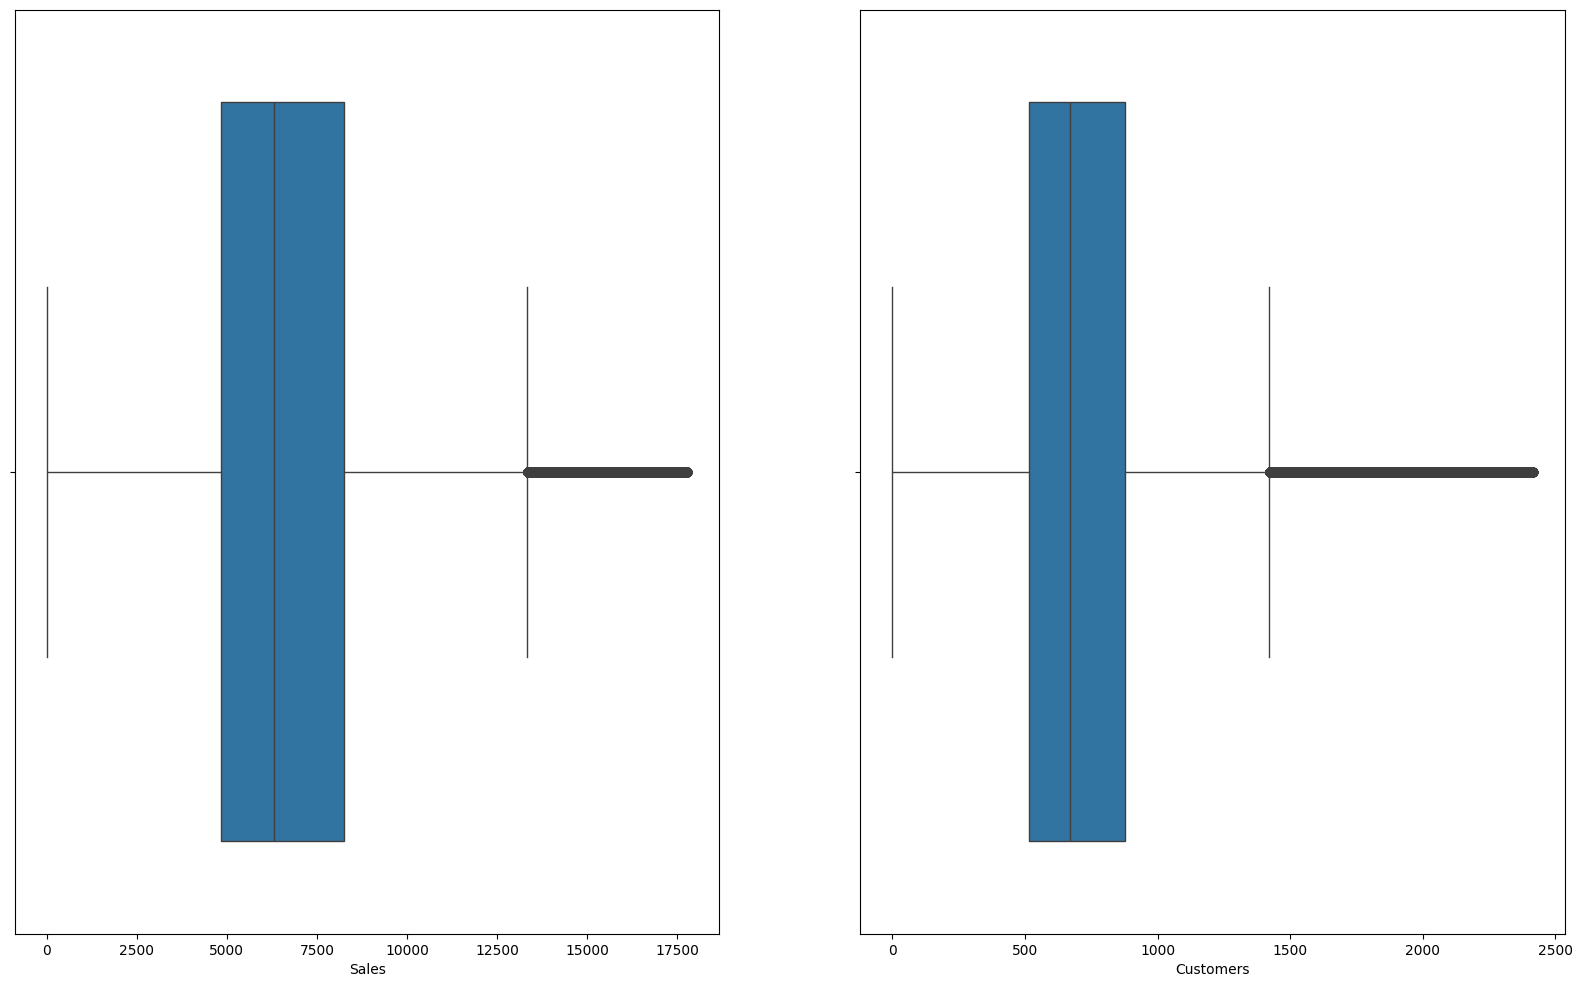

In [37]:
# Checking the Boxlots for "Train" dataset again after capping the values at 99th percentile

plot_boxplots(df_train_transformed, train_boxplot_cols)

#### *Inference: Outliers for "Train" dataset have been treated.*

In [38]:
df_store_transformed.shape

(1115, 10)

In [39]:
df_train_transformed.shape

(831626, 9)

In [40]:
# Resetting the index for both "Store" and "Train" datasets

# Resetting the index for "Store" dataset
df_store_transformed = df_store_transformed.reset_index()

# Resetting the index for "Train" dataset
df_train_transformed = df_train_transformed.reset_index()

In [41]:
# Displaying "Store" dataset

df_store_transformed.head()

index  Store StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear    PromoInterval
0      0      1         c          a               1270.0                        9.0                    2008.0       0              0.0              0.0                0
1      1      2         a          a                570.0                       11.0                    2007.0       1             13.0           2010.0  Jan,Apr,Jul,Oct
2      2      3         a          a              14130.0                       12.0                    2006.0       1             14.0           2011.0  Jan,Apr,Jul,Oct
3      3      4         c          c                620.0                        9.0                    2009.0       0              0.0              0.0                0
4      4      5         a          a              29910.0                        4.0                    2015.0       0              0.0              0.0                0

In [42]:
# Checking the shape of the "Store" dataset

df_store_transformed.shape

(1115, 11)

In [43]:
# Displaying "Train" dataset

df_train_transformed.head()

index  Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  SchoolHoliday
0      0      1          5  2015-07-31   5263        555     1      1            0              1
1      1      2          5  2015-07-31   6064        625     1      1            0              1
2      2      3          5  2015-07-31   8314        821     1      1            0              1
3      3      4          5  2015-07-31  13995       1498     1      1            0              1
4      4      5          5  2015-07-31   4822        559     1      1            0              1

In [44]:
# Checking the shape of the "Train" dataset

df_train_transformed.shape

(831626, 10)

#### Merging "Store" and "Train" datasets on "Store" column

In [45]:
# Merging "Store" and "Train" datasets

df_merged = df_train_transformed.merge(right = df_store_transformed, on = "Store", how = "inner")

In [46]:
# Removing the "index" columns of "Train" and "Store" datasets

df_merged_transformed = df_merged.drop(["index_x", "index_y"], axis = 1)

In [47]:
# Displaying "Merged" dataset

df_merged_transformed.head()

Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  SchoolHoliday StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear    PromoInterval
0      1          5  2015-07-31   5263        555     1      1            0              1         c          a               1270.0                        9.0                    2008.0       0              0.0              0.0                0
1      2          5  2015-07-31   6064        625     1      1            0              1         a          a                570.0                       11.0                    2007.0       1             13.0           2010.0  Jan,Apr,Jul,Oct
2      3          5  2015-07-31   8314        821     1      1            0              1         a          a              14130.0                       12.0                    2006.0       1             14.0           2011.0  Jan,Apr,Jul,Oct
3      4          5  2015-07-31  13995       1498     1      1            0              1         c          c                620.0                        9.0                    2009.0       0              0.0              0.0                0
4      5          5  2015-07-31   4822        559     1      1            0              1         a          a              29910.0                        4.0                    2015.0       0              0.0              0.0                0

In [48]:
# Checking the shape of "Merged" dataset

df_merged_transformed.shape

(831626, 18)

In [49]:
# Checking the datatype of the columns of "Merged" dataset

df_merged_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 831626 entries, 0 to 831625
Data columns (total 18 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Store                      831626 non-null  int64  
 1   DayOfWeek                  831626 non-null  int64  
 2   Date                       831626 non-null  object 
 3   Sales                      831626 non-null  int64  
 4   Customers                  831626 non-null  int64  
 5   Open                       831626 non-null  int64  
 6   Promo                      831626 non-null  int64  
 7   StateHoliday               831626 non-null  object 
 8   SchoolHoliday              831626 non-null  int64  
 9   StoreType                  831626 non-null  object 
 10  Assortment                 831626 non-null  object 
 11  CompetitionDistance        831626 non-null  float64
 12  CompetitionOpenSinceMonth  831626 non-null  float64
 13  CompetitionOpenSinceYear   83

In [50]:
# Checking percentage of missing/null values

round(100*(df_merged_transformed.isnull().sum()/len(df_merged_transformed)),2)

Store                        0.0
DayOfWeek                    0.0
Date                         0.0
Sales                        0.0
Customers                    0.0
Open                         0.0
Promo                        0.0
StateHoliday                 0.0
SchoolHoliday                0.0
StoreType                    0.0
Assortment                   0.0
CompetitionDistance          0.0
CompetitionOpenSinceMonth    0.0
CompetitionOpenSinceYear     0.0
Promo2                       0.0
Promo2SinceWeek              0.0
Promo2SinceYear              0.0
PromoInterval                0.0
dtype: float64

#### *Inference: No null values are present in the "Merged" dataset*

### (ii) Bivariate Analysis

In [51]:
# Creating a UDF to plot the boxplots of various variable w.r.t "Sales" column

def boxplot_bivariate(df, column_list):

    num_attributes = len(column_list)
    num_rows = (num_attributes - 1) // 3 + 1
    num_cols = min(num_attributes, 3)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 6*num_rows))

    axes = axes.flatten()

    for i, attribute in enumerate(column_list):
        sns.boxplot(x=attribute, y="Sales", data=df, ax=axes[i])
        axes[i].set_title(f"Sales vs {attribute}")

    for j in range(num_attributes, len(axes)):
        fig.delaxes(axes[j])

    plt.show()

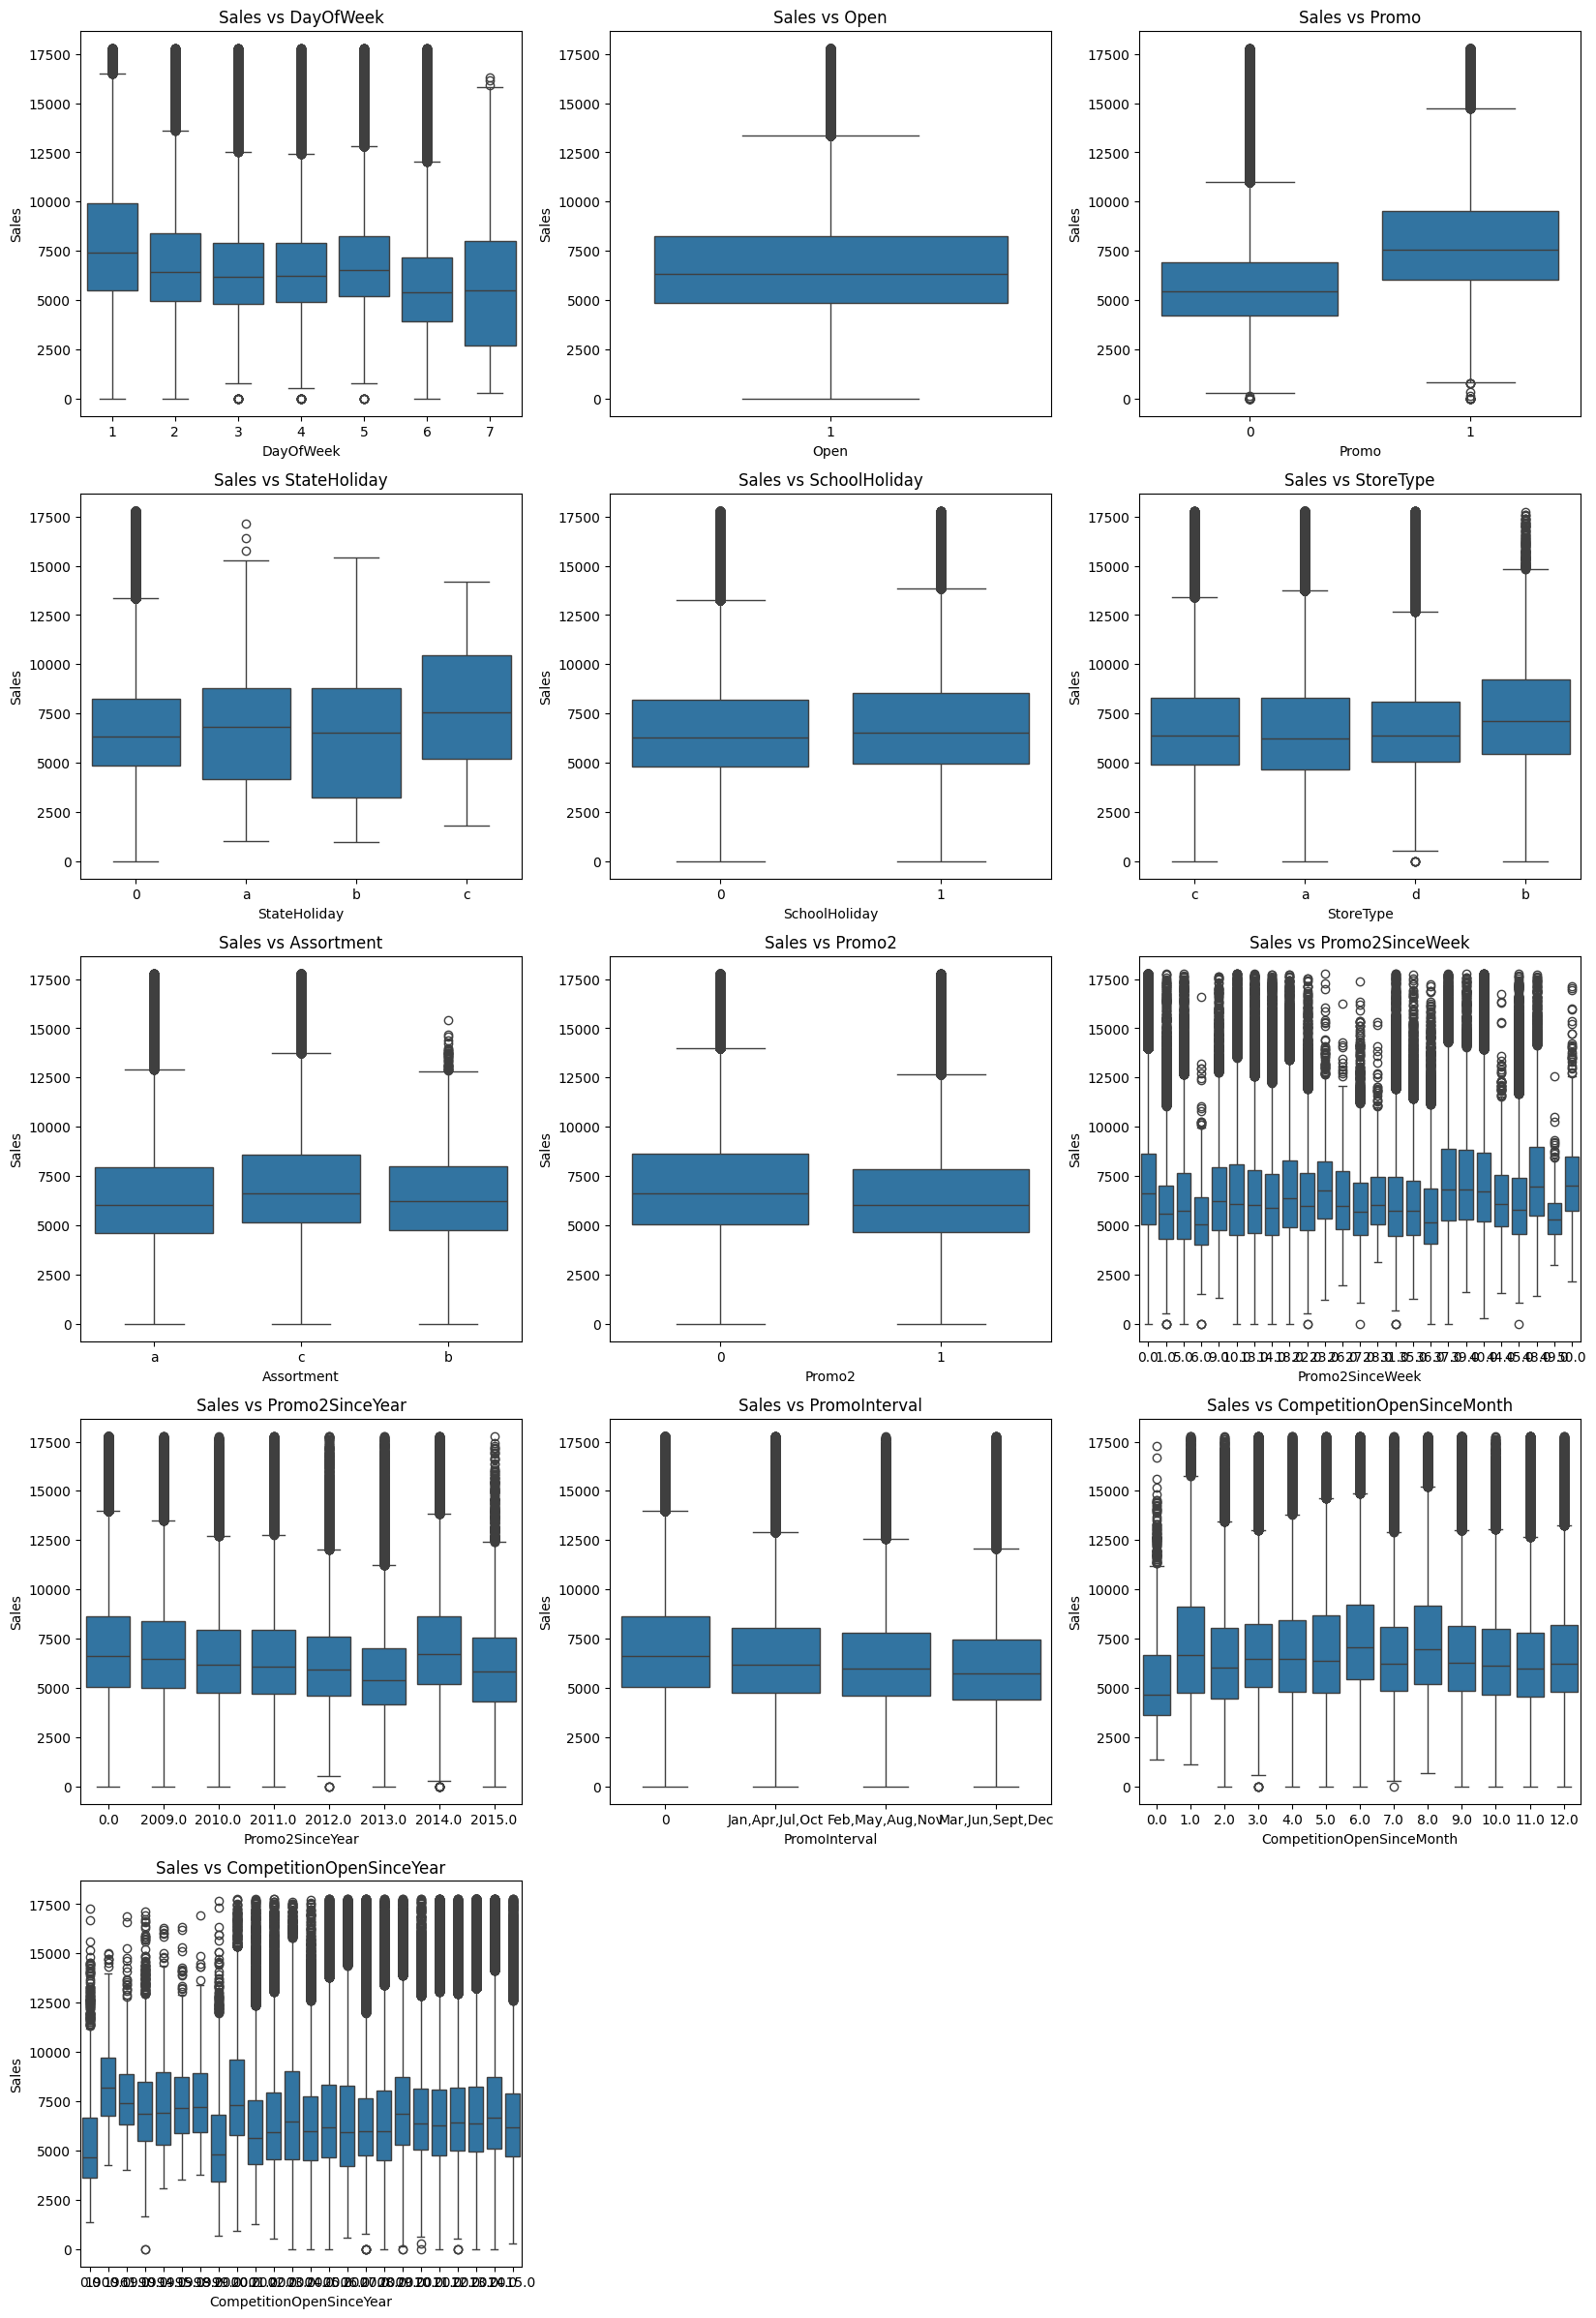

In [52]:
# Selecting the columns to display their boxplots

bivariate_boxplotcols = ["DayOfWeek", "Open", "Promo", "StateHoliday", "SchoolHoliday", "StoreType",
                         "Assortment", "Promo2", "Promo2SinceWeek", "Promo2SinceYear", "PromoInterval",
                         "CompetitionOpenSinceMonth", "CompetitionOpenSinceYear"]

# Plotting the boxplots using "boxplot_bivariate" function

boxplot_bivariate(df_merged_transformed, bivariate_boxplotcols)

#### Inferences from the graphs of "Merged" dataset:

Sales tend to be strongest on Mondays, Tuesdays, and Fridays, while they drop significantly on Saturdays and Sundays.

- Promotions have a noticeable impact, with sales increasing sharply whenever a promotion is active.
- Stores experience higher sales on public holidays categorized as "C" compared to those labeled "A" or "B."
- Interestingly, school holidays don't seem to influence sales at all.
- Among store types, "B" stands out with a higher share of total sales.
- When it comes to product assortment, stores offering type "C" see the best sales performance.
- Certain factors, like "Promo2," "Promo2SinceWeek," "Promo2SinceYear," "PromoInterval," "CompetitionOpenSinceMonth," and "CompetitionOpenSinceYear," appear to have little to no impact on overall sales.

#### Scatter plot Analysis

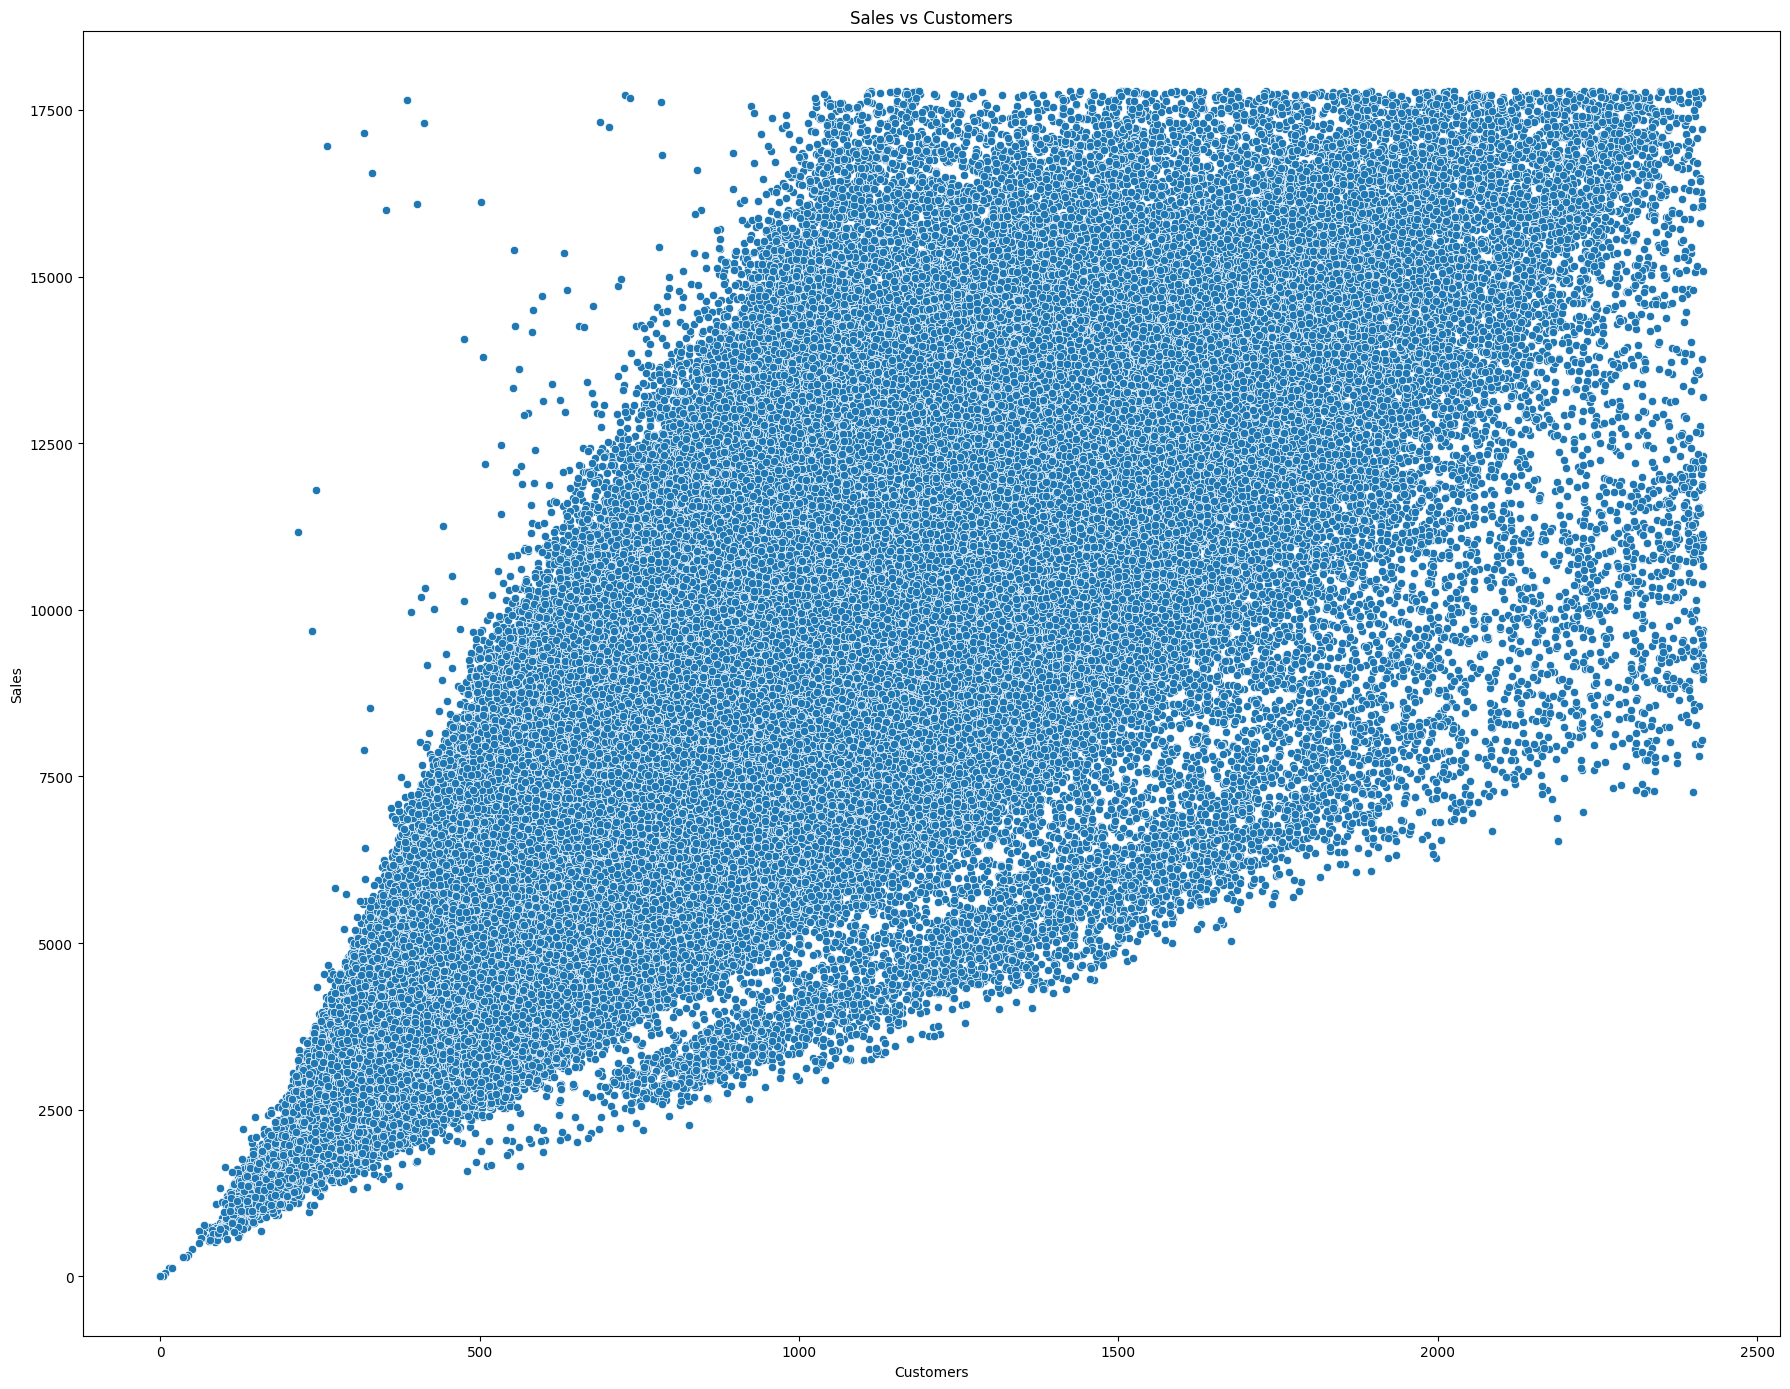

In [53]:
# Scatter plot: Sales Vs Customers

sns.scatterplot(x = "Customers", y = "Sales", data = df_merged_transformed)
plt.title("Sales vs Customers")
plt.tight_layout()
plt.show()

#### *Inference: An increase in the number of customers correlates with higher sales.*

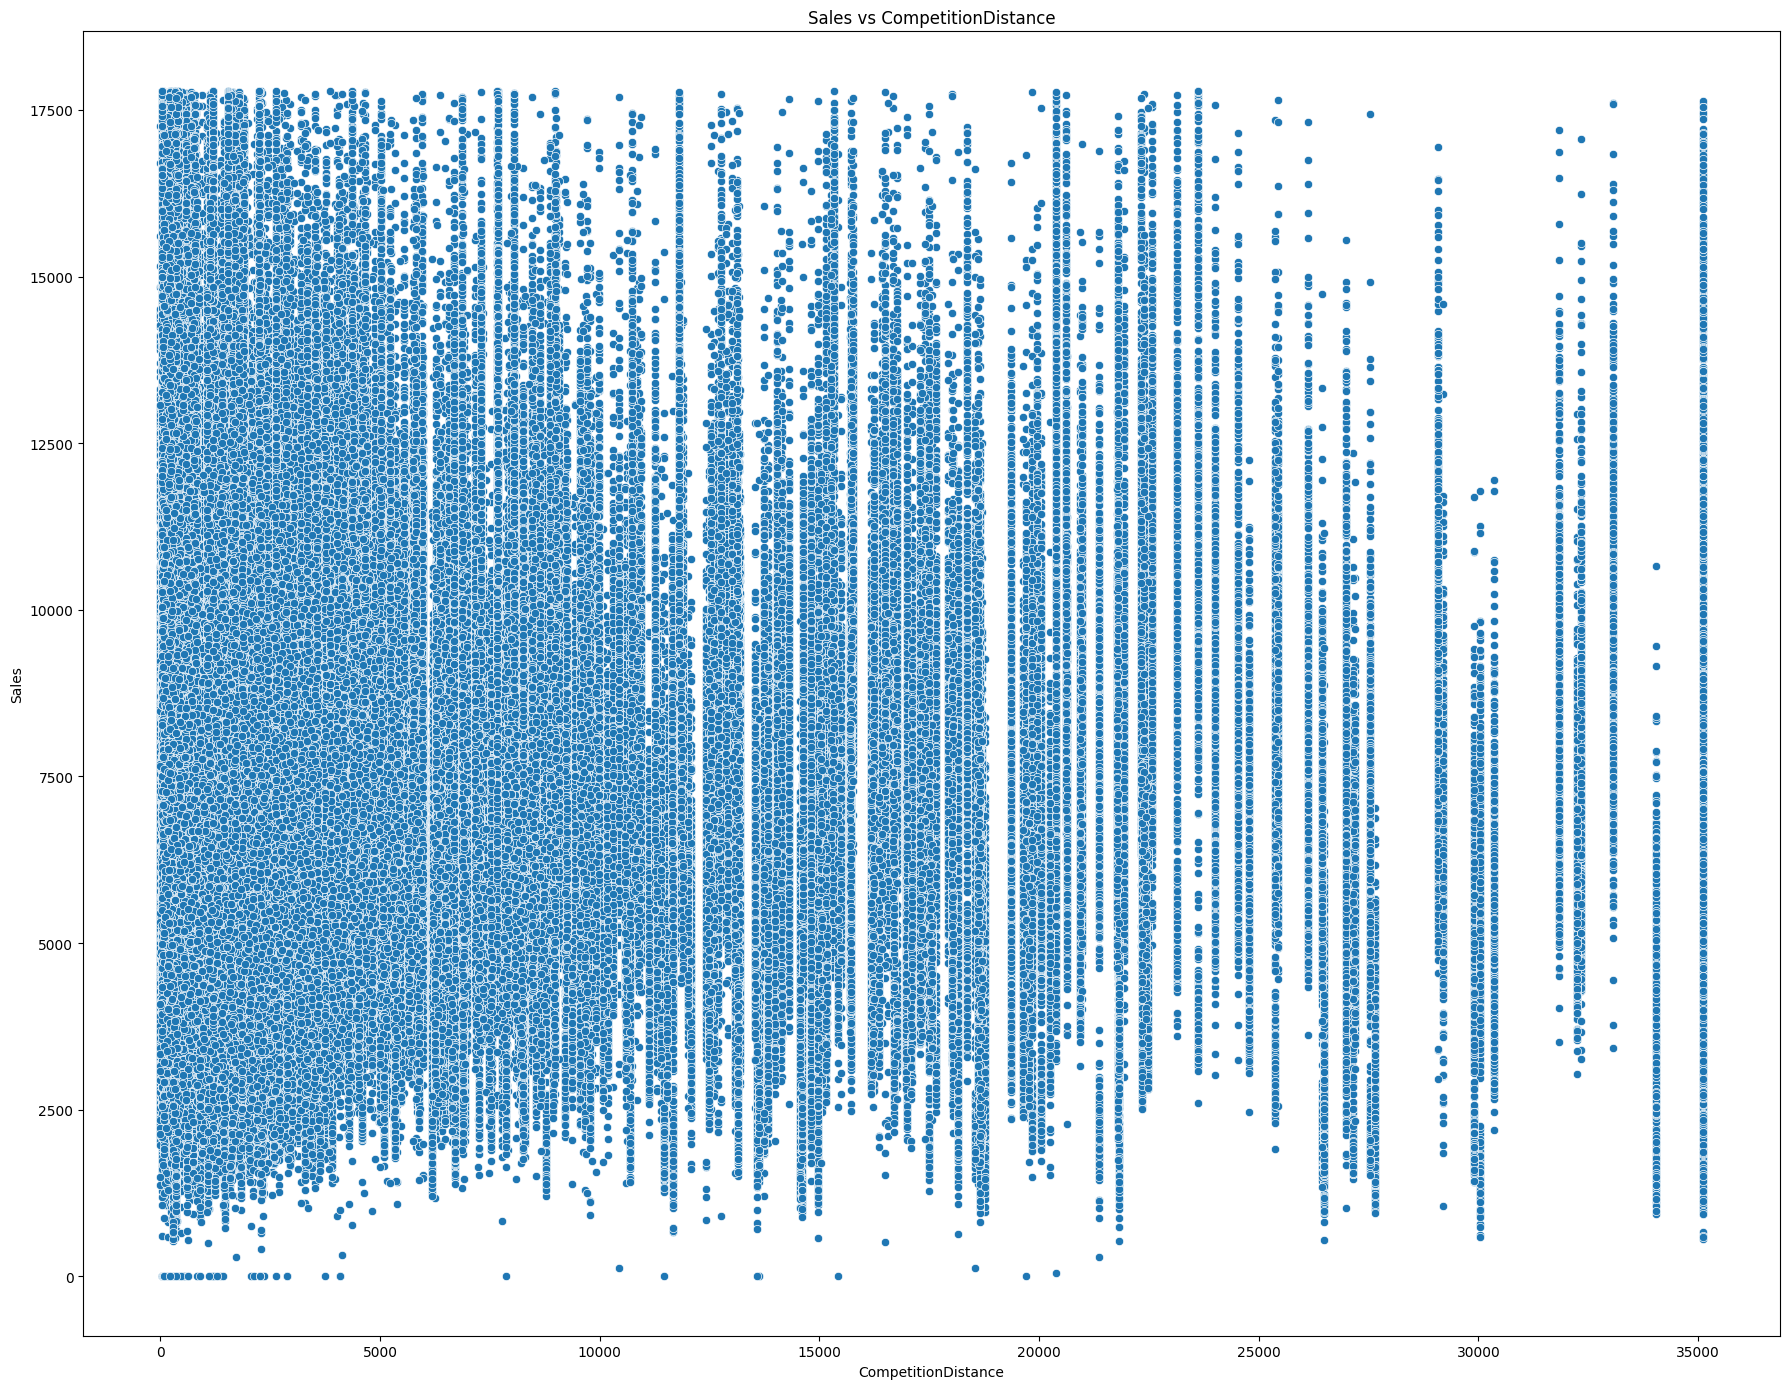

In [54]:
# Scatter plot: Sales Vs CompetitionDistance

sns.scatterplot(x = "CompetitionDistance", y = "Sales", data = df_merged_transformed)
plt.title("Sales vs CompetitionDistance")
plt.tight_layout()
plt.show()

#### *Inference: There appears to be no correlation between "CompetitionDistance" and "Sales".*

### (iii) Multivariate Analysis

#### (a) Categorical Variables

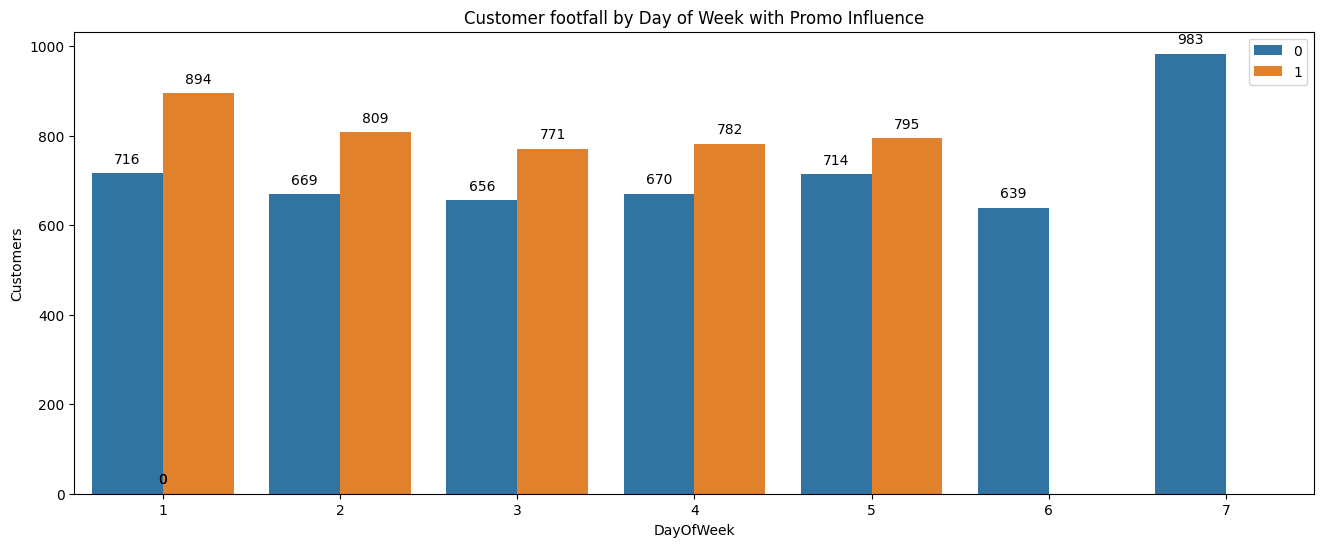

In [55]:
# Barplot to check co-relation: Customers vs DayOfWeek with influece of "Promo"

plt.figure(figsize=(16, 6))
ax = sns.barplot(x="DayOfWeek",y="Customers",hue="Promo", data=df_merged_transformed, ci=None)
plt.title("Customer footfall by Day of Week with Promo Influence")
plt.xticks()
plt.legend(loc="upper right")

# Add data labels at the top of each bar

for p in ax.patches:
    ax.annotate(format(p.get_height(), ".0f"),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = "center", va = "center",
                xytext = (0, 10),
                textcoords = "offset points")
plt.show()

#### Inferences-

- Weekdays witness a surge in customer numbers, particularly when promotions are in effect
- "Promo" exhibit a robust correlation with the store sales

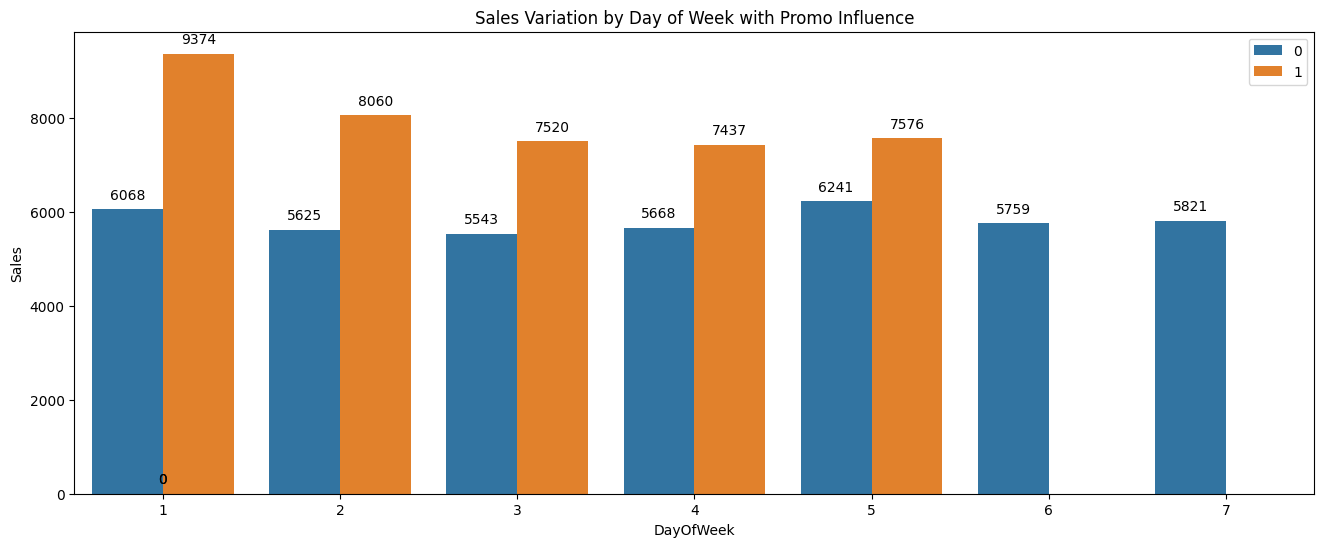

In [56]:
# Barplot to check co-relation: Sales vs DayOfWeek with influece of "Promo"

plt.figure(figsize=(16, 6))
ax = sns.barplot(x="DayOfWeek",y="Sales",hue="Promo", data=df_merged_transformed, ci=None)
plt.title("Sales Variation by Day of Week with Promo Influence")
plt.xticks()
plt.legend(loc="upper right")

# Add data labels at the top of each bar

for p in ax.patches:
    ax.annotate(format(p.get_height(), ".0f"),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = "center", va = "center",
                xytext = (0, 10),
                textcoords = "offset points")
plt.show()

#### Inferences-

- Sales peak on the Monday (1), Tuesday (2), and Friday (5) weekdays, while reducing considerably on Saturday (6) and Sunday (7)
- "Promo" exhibit a robust correlation with the store sales

#### (b) Numerical Variables

<Figure size 3000x3000 with 0 Axes>

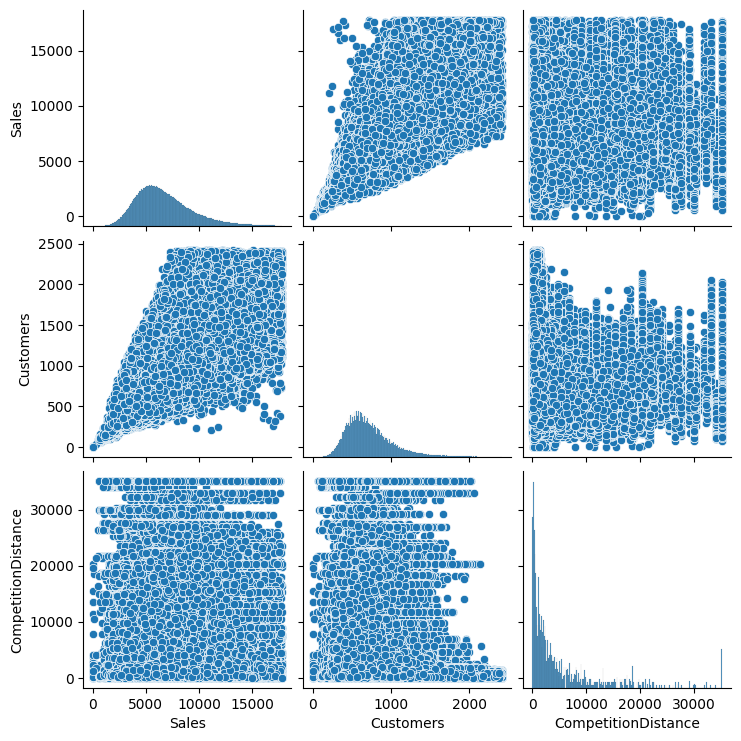

In [57]:
# Pairwise plot

plt.figure(figsize=(30, 30))
sns.pairplot(df_merged_transformed[["Sales","Customers","CompetitionDistance"]])
plt.show()

#### *Inference: Sales tend to increase with a rise in the number of customers*

## Step 5: Feature Engineering

### Removing unwanted columns

In [58]:
# Dropping the unnecessary columns

drop_cols = ["Promo2","SchoolHoliday","Promo2SinceWeek","Promo2SinceYear","PromoInterval",
             "CompetitionOpenSinceMonth", "CompetitionOpenSinceYear", "CompetitionDistance", "Open"]

df_merge_required = df_merged_transformed.drop(drop_cols, axis=1)

In [59]:
# Displaying the "df_merge_required" dataframe

df_merge_required.head()

Store  DayOfWeek        Date  Sales  Customers  Promo StateHoliday StoreType Assortment
0      1          5  2015-07-31   5263        555      1            0         c          a
1      2          5  2015-07-31   6064        625      1            0         a          a
2      3          5  2015-07-31   8314        821      1            0         a          a
3      4          5  2015-07-31  13995       1498      1            0         c          c
4      5          5  2015-07-31   4822        559      1            0         a          a

In [60]:
# Checking the shape of the "df_merge_required" dataframe

df_merge_required.shape

(831626, 9)

In [61]:
# Converting "Date" to "yyyy-mm-dd" date format

df_merge_required["Date"] = pd.to_datetime(df_merge_required["Date"], format="%Y-%m-%d")

### Creating Dummy Variables

In [62]:
# Creating Dummy Variable: "DayOfWeek"

dow_dummy = pd.get_dummies(df_merge_required.DayOfWeek, drop_first=True, prefix= "DayOfWeek")

# Creating Dummy Variable: "StoreType"

stype_dummy = pd.get_dummies(df_merge_required.StoreType, drop_first=True, prefix= "StoreType")

# Creating Dummy Variable: "Assortment"

assort_dummy = pd.get_dummies(df_merge_required.Assortment, drop_first=True, prefix= "Assortment")

# Creating Dummy Variable: "StateHoliday"

sholiday_dummy = pd.get_dummies(df_merge_required.StateHoliday, drop_first=True, prefix= "StateHoliday")

In [63]:
# Merging all the dummies together

df_dummies_merged = pd.concat([df_merge_required, dow_dummy, stype_dummy, assort_dummy, sholiday_dummy], axis=1)

# Dropping the original columns using which dummies were formed

df_dummies_merged = df_dummies_merged.drop(["StoreType","DayOfWeek","Assortment", "StateHoliday"], axis=1)

In [64]:
# Displaying the "df_dummies_merged" dataframe

df_dummies_merged.head(5)

Store       Date  Sales  Customers  Promo  DayOfWeek_2  DayOfWeek_3  DayOfWeek_4  DayOfWeek_5  DayOfWeek_6  DayOfWeek_7  StoreType_b  StoreType_c  StoreType_d  Assortment_b  Assortment_c  StateHoliday_0  StateHoliday_a  StateHoliday_b  StateHoliday_c
0      1 2015-07-31   5263        555      1        False        False        False         True        False        False        False         True        False         False         False            True           False           False           False
1      2 2015-07-31   6064        625      1        False        False        False         True        False        False        False        False        False         False         False            True           False           False           False
2      3 2015-07-31   8314        821      1        False        False        False         True        False        False        False        False        False         False         False            True           False           False           False
3      4 2015-07-31  13995       1498      1        False        False        False         True        False        False        False         True        False         False          True            True           False           False           False
4      5 2015-07-31   4822        559      1        False        False        False         True        False        False        False        False        False         False         False            True           False           False           False

In [65]:
# Checking the shape of the "df_dummies_merged" dataframe

df_dummies_merged.shape

(831626, 20)

## Step 6: Time Series Analysis

#### *Insight: Based on our analysis done earlier, we observed that a rise in the number of customers leads directly to an increase in sales. Hence, the count of customers can be considered as an endogenous variable for our predictions.*

In [66]:
df_dummies_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 831626 entries, 0 to 831625
Data columns (total 20 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Store           831626 non-null  int64         
 1   Date            831626 non-null  datetime64[ns]
 2   Sales           831626 non-null  int64         
 3   Customers       831626 non-null  int64         
 4   Promo           831626 non-null  int64         
 5   DayOfWeek_2     831626 non-null  bool          
 6   DayOfWeek_3     831626 non-null  bool          
 7   DayOfWeek_4     831626 non-null  bool          
 8   DayOfWeek_5     831626 non-null  bool          
 9   DayOfWeek_6     831626 non-null  bool          
 10  DayOfWeek_7     831626 non-null  bool          
 11  StoreType_b     831626 non-null  bool          
 12  StoreType_c     831626 non-null  bool          
 13  StoreType_d     831626 non-null  bool          
 14  Assortment_b    831626 non-null  boo

In [67]:
# Setting "Date" as index

df_dummies_transformed = df_dummies_merged.set_index("Date")

In [68]:
# Disiplaying the "df_dummies_transformed" dataframe

df_dummies_transformed.head()

Store  Sales  Customers  Promo  DayOfWeek_2  DayOfWeek_3  DayOfWeek_4  DayOfWeek_5  DayOfWeek_6  DayOfWeek_7  StoreType_b  StoreType_c  StoreType_d  Assortment_b  Assortment_c  StateHoliday_0  StateHoliday_a  StateHoliday_b  StateHoliday_c
Date                                                                                                                                                                                                                                                       
2015-07-31      1   5263        555      1        False        False        False         True        False        False        False         True        False         False         False            True           False           False           False
2015-07-31      2   6064        625      1        False        False        False         True        False        False        False        False        False         False         False            True           False           False           False
2015-07-31      3   8314        821      1        False        False        False         True        False        False        False        False        False         False         False            True           False           False           False
2015-07-31      4  13995       1498      1        False        False        False         True        False        False        False         True        False         False          True            True           False           False           False
2015-07-31      5   4822        559      1        False        False        False         True        False        False        False        False        False         False         False            True           False           False           False

In [69]:
# Checking the shape of "df_dummies_transformed" dataframe

df_dummies_transformed.shape

(831626, 19)

In [70]:
# Aggregating the data for building models

df_train_grouped = df_dummies_transformed.groupby(["Date"]).agg({"Sales": "mean",
                                                                 "Customers":"mean",
                                                                 "Promo": "sum",
                                                                 "DayOfWeek_2":"mean","DayOfWeek_3":"mean",
                                                                 "DayOfWeek_4":"mean","DayOfWeek_5":"mean",
                                                                 "DayOfWeek_6":"mean","DayOfWeek_7":"mean",
                                                                 "StoreType_b" : "mean","StoreType_c" : "mean","StoreType_d" : "mean",
                                                                 "Assortment_b":"mean", "Assortment_c":"mean",
                                                                 "StateHoliday_a":"mean","StateHoliday_b":"mean","StateHoliday_c":"mean"})

In [71]:
# Displaying the "df_train_grouped" dataframe

df_train_grouped.head()

Sales    Customers  Promo  DayOfWeek_2  DayOfWeek_3  DayOfWeek_4  DayOfWeek_5  DayOfWeek_6  DayOfWeek_7  StoreType_b  StoreType_c  StoreType_d  Assortment_b  Assortment_c  StateHoliday_a  StateHoliday_b  StateHoliday_c
Date                                                                                                                                                                                                                                        
2013-01-01  4998.000000  1038.500000      0          1.0          0.0          0.0          0.0          0.0          0.0     0.937500     0.000000     0.000000      0.562500      0.125000             1.0             0.0             0.0
2013-01-02  6132.214545   732.165455      0          0.0          1.0          0.0          0.0          0.0          0.0     0.011818     0.132727     0.313636      0.007273      0.457273             0.0             0.0             0.0
2013-01-03  5648.392015   673.737750      0          0.0          0.0          1.0          0.0          0.0          0.0     0.011797     0.132486     0.313067      0.007260      0.458258             0.0             0.0             0.0
2013-01-04  5908.981818   692.341818      0          0.0          0.0          0.0          1.0          0.0          0.0     0.010909     0.131818     0.313636      0.006364      0.457273             0.0             0.0             0.0
2013-01-05  5289.219290   606.239308      0          0.0          0.0          0.0          0.0          1.0          0.0     0.011829     0.131938     0.314832      0.006369      0.456779             0.0             0.0             0.0

In [72]:
# Checking the shape of the "df_train_grouped" dataframe

df_train_grouped.shape

(942, 17)

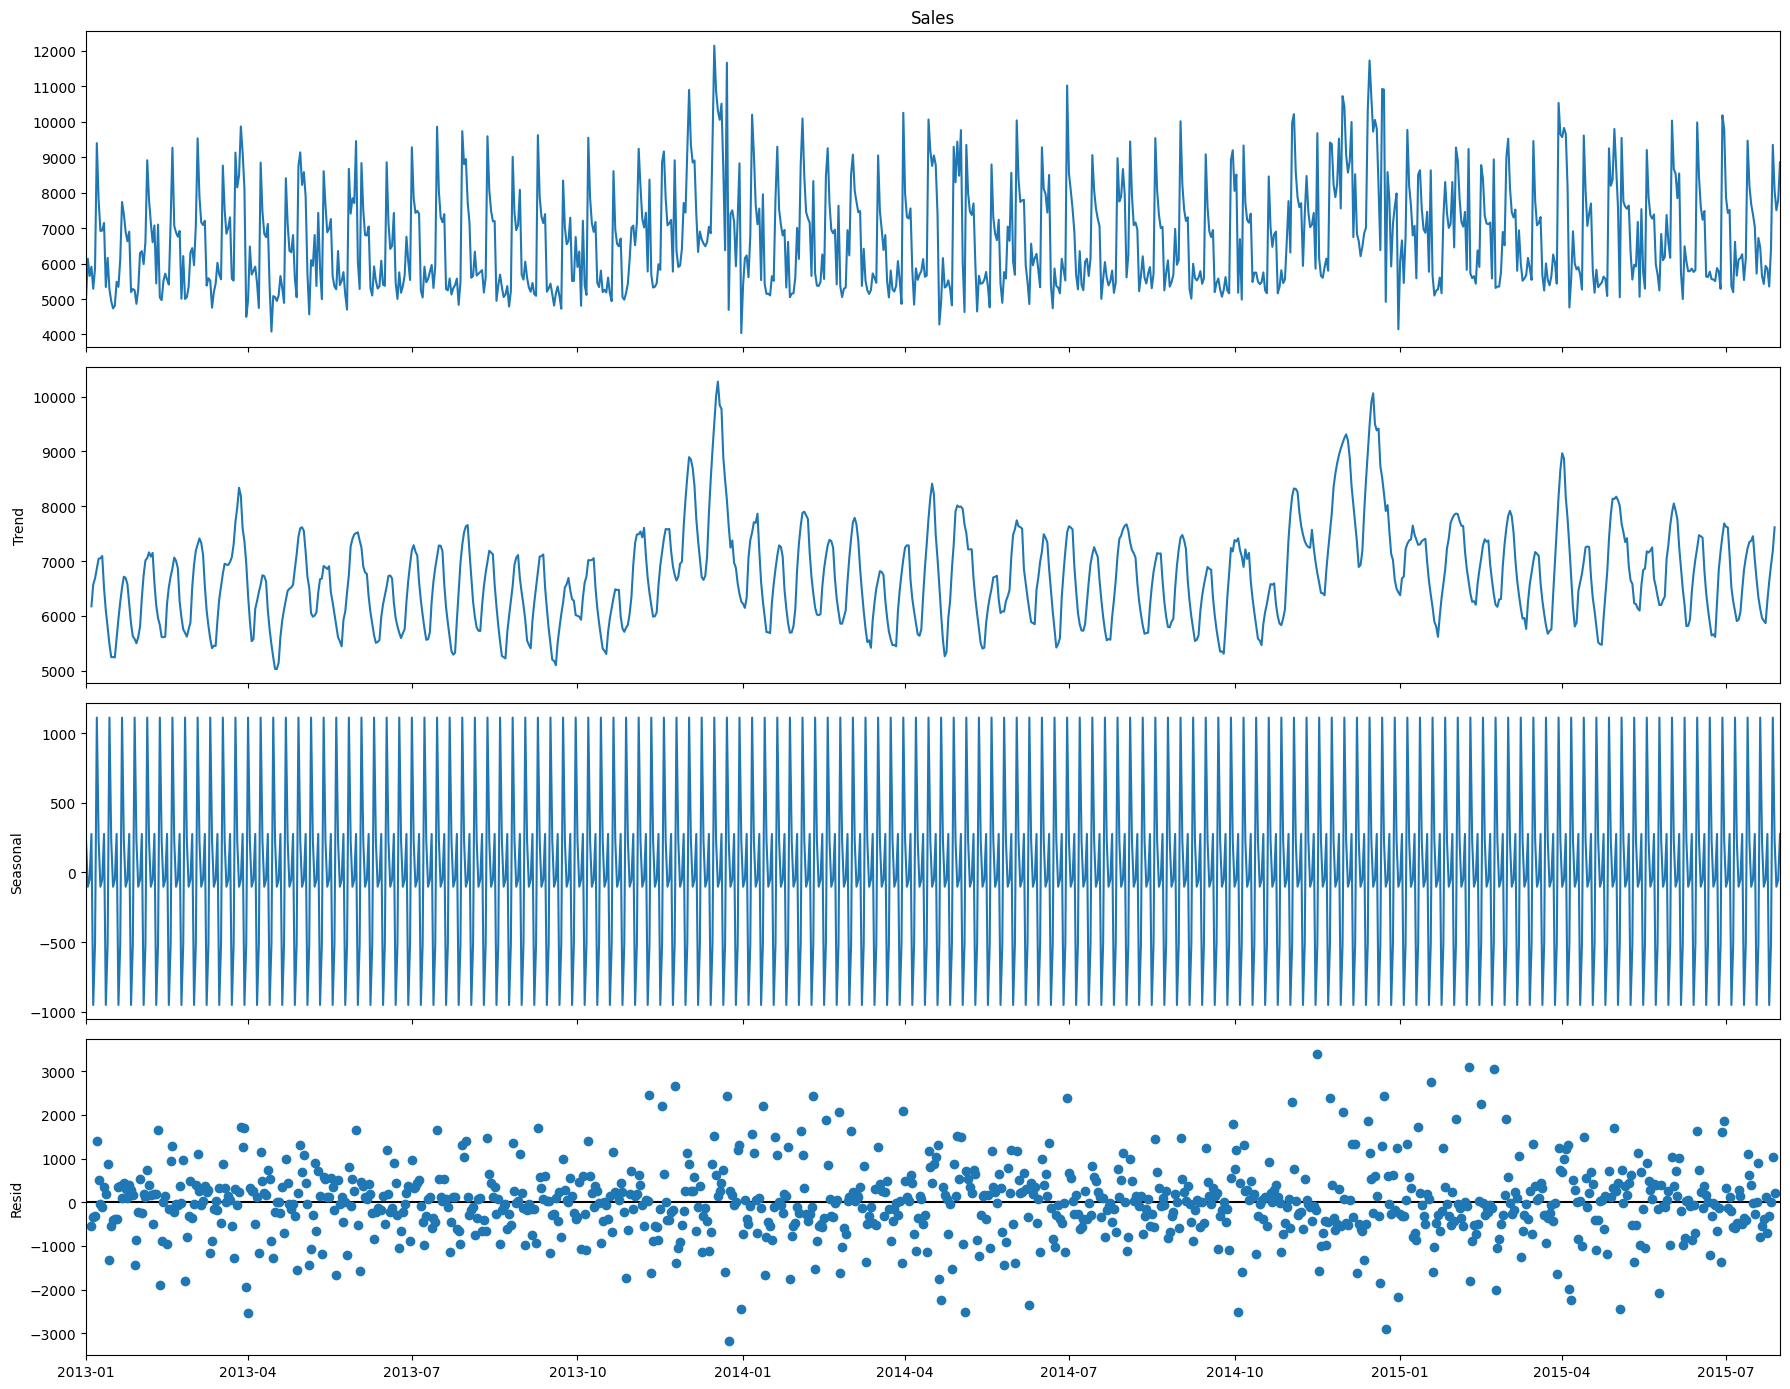

In [73]:
# Seasonal Decomposition: "Additive"

add_decomposition = sm.tsa.seasonal_decompose(df_train_grouped.Sales, model="additive")
fig = add_decomposition.plot()
plt.show()

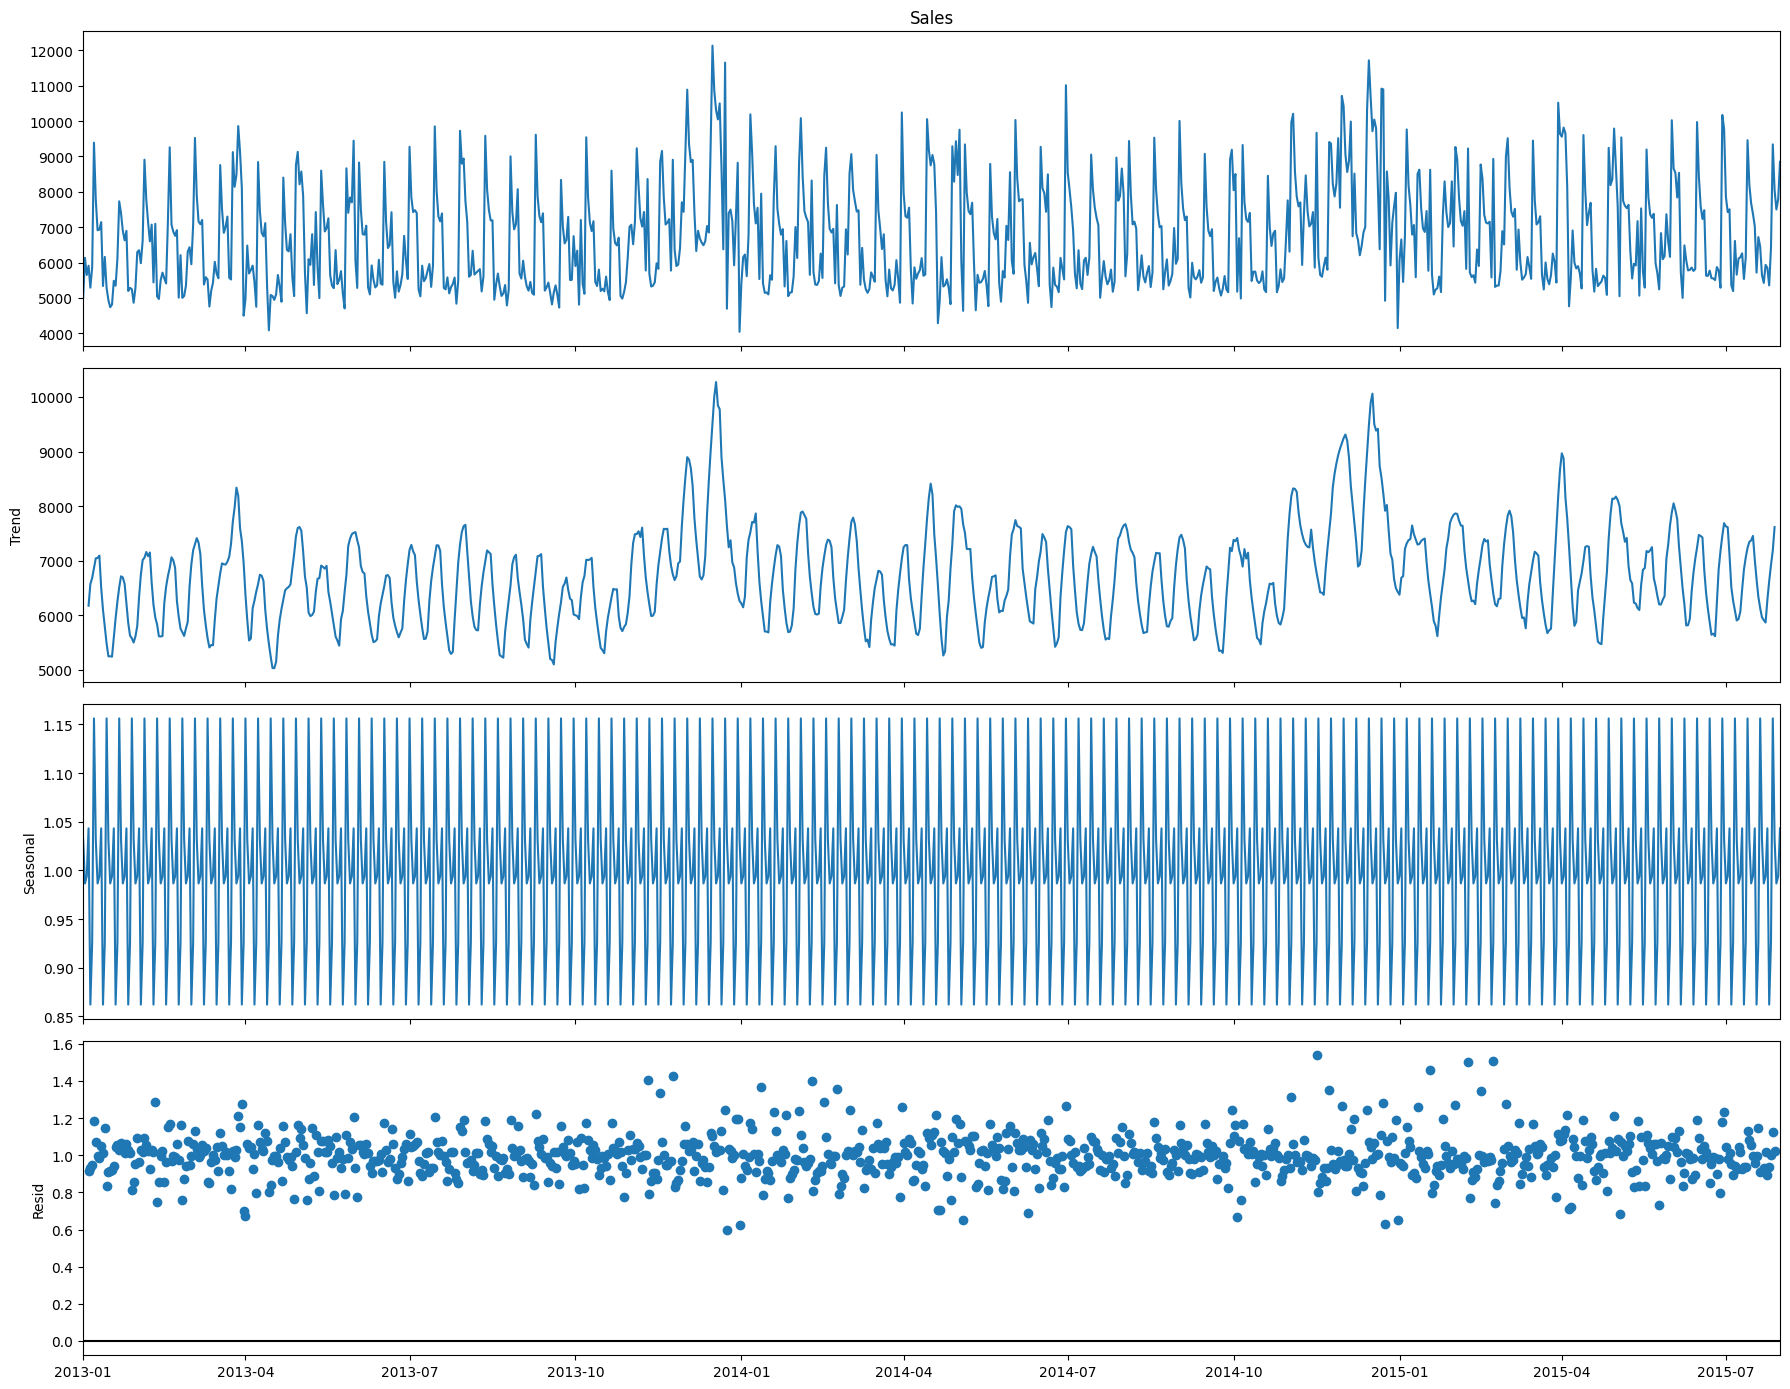

In [74]:
# Seasonal Decomposition: "Multiplicative"

multiply_decomposition = sm.tsa.seasonal_decompose(df_train_grouped.Sales, model="multiplicative")
fig = multiply_decomposition.plot()
plt.show()

### Checking for Stationarity

#### (i) Column: "Sales"

In [75]:
# Creating a copy

df_train_data = df_train_grouped.copy()

In [76]:
# Adfuller test

adf_test = adfuller(df_train_data["Sales"])

print("ADF Statistics: ", adf_test[0])
print("Critical Value @ 0.05: ", adf_test[4]["5%"])
print("p-value: ", adf_test[1])

if adf_test[0]<adf_test[4]["5%"] and adf_test[1] < 0.05:
    print("Series is stationary")
else:
    print("Series is not stationary")

ADF Statistics:  -4.584875354682698
Critical Value @ 0.05:  -2.8646798473884134
p-value:  0.0001377198969727135
Series is stationary


In [77]:
# Differencing the series

df_sales_diff = pd.Series(df_train_data["Sales"].diff(), index = df_train_data.index)
df_sales_diff.dropna(inplace=True)

In [78]:
# Displaying the "df_sales_diff" dataframe

df_sales_diff.head()

Date
2013-01-02    1134.214545
2013-01-03    -483.822531
2013-01-04     260.589804
2013-01-05    -619.762528
2013-01-06     570.780710
Name: Sales, dtype: float64

In [79]:
# Adfuller test

adf_test_diff = adfuller(df_sales_diff)

print("ADF Statistics: ", adf_test_diff[0])
print("Critical Value @ 0.05: ", adf_test_diff[4]["5%"])
print("p-value: ", adf_test_diff[1])

if adf_test_diff[0] < adf_test_diff[4]["5%"] and adf_test_diff[1] < 0.05:
    print("Series is stationary")
else:
    print("Series is not stationary")

ADF Statistics:  -12.09835163104141
Critical Value @ 0.05:  -2.8646832620852853
p-value:  2.0456054451287063e-22
Series is stationary


#### (ii) Column: "Customers"

In [80]:
# Adfuller test

adf_test_cust = adfuller(df_train_data["Customers"])

print("ADF Statistics: ", adf_test_cust[0])
print("Critical Value @ 0.05: ", adf_test_cust[4]["5%"])
print("p-value: ", adf_test_cust[1])

if adf_test[0]<adf_test[4]["5%"] and adf_test_cust[1] < 0.05:
    print("Series is stationary")
else:
    print("Series is not stationary")

ADF Statistics:  -4.9368459832380225
Critical Value @ 0.05:  -2.8646662624723502
p-value:  2.955031863482e-05
Series is stationary


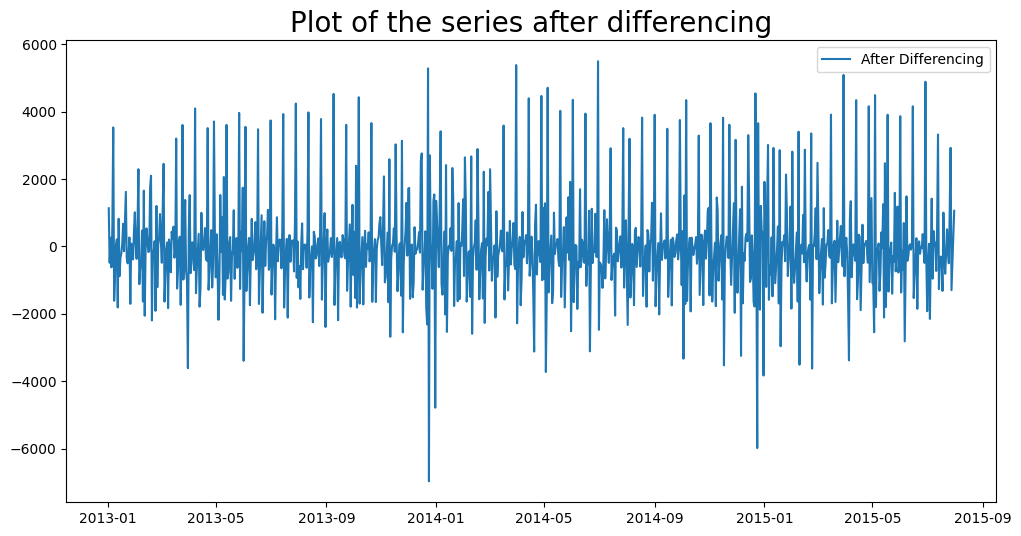

In [81]:
# Plotting the "Difference" series

plt.figure(figsize=[12,6])
plt.plot(df_sales_diff, label="After Differencing")
plt.title("Plot of the series after differencing", size=20)
plt.legend(loc = "best")
plt.show()

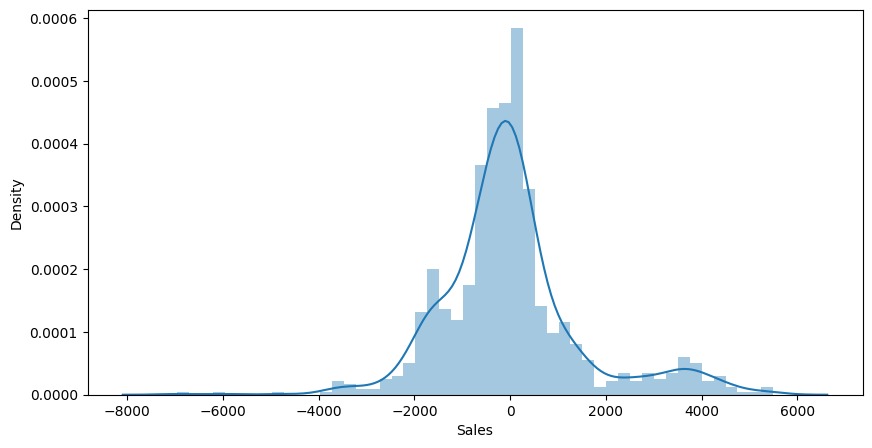

In [82]:
# Distribution plot for "df_sales_diff"

plt.figure(figsize=(10,5))
sns.distplot(df_sales_diff)
plt.show()

#### *Inference: "Sales" and "Customers" columns are stationary* and we <u> don"t need  box-cox transformation </u>.

### Plotting ACF and PACF Plots

#### Column: "Sales"

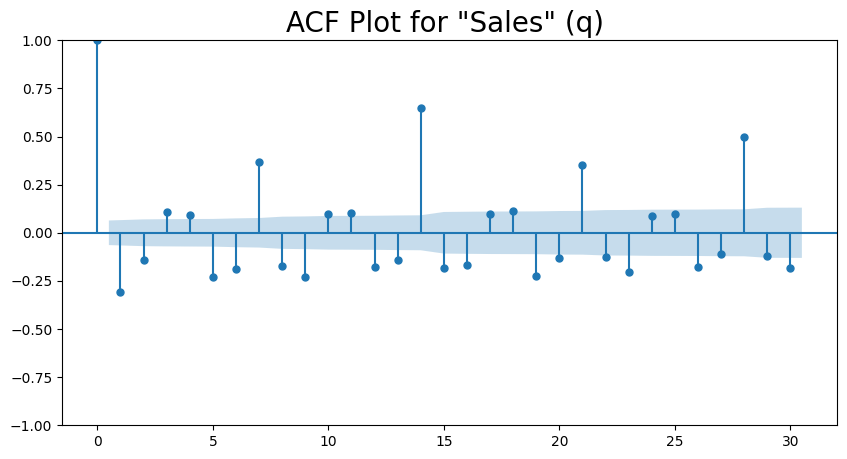

In [83]:
# ACF Plot for "Sales" column with 30 lags

plt.figure(figsize=[10,5])
plot_acf(df_sales_diff, ax=plt.gca(), lags=30)
plt.title("ACF Plot for \"Sales\" (q) ", size=20, color="black")
plt.show()

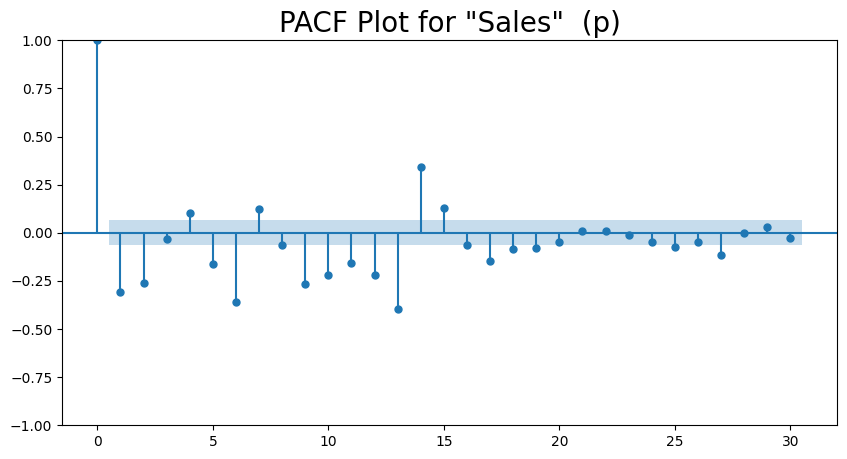

In [84]:
# PACF Plot for "Sales" column with 30 lags

plt.figure(figsize=[10,5])
plot_pacf(df_sales_diff, ax=plt.gca(), lags=30)
plt.title("PACF Plot for \"Sales\"  (p)", size=20, color="black")
plt.show()

#### *Inference*:
- p = 6
- q = 1 or 7

### Train & Test Data Split

- As we have to predict for the 6 weeks, we will take 42 days as our "Test" dataset.

In [86]:
df_train_data.shape

(942, 17)

In [87]:
# Selecting 900 (942 - 90) as the length of our "Train" Dataset

len_train = 900

df_train_values = df_train_data[:len_train]
df_test_values = df_train_data[len_train:]

In [88]:
# Displaying the "Train" dataset

df_train_values.head()

Sales    Customers  Promo  DayOfWeek_2  DayOfWeek_3  DayOfWeek_4  DayOfWeek_5  DayOfWeek_6  DayOfWeek_7  StoreType_b  StoreType_c  StoreType_d  Assortment_b  Assortment_c  StateHoliday_a  StateHoliday_b  StateHoliday_c
Date                                                                                                                                                                                                                                        
2013-01-01  4998.000000  1038.500000      0          1.0          0.0          0.0          0.0          0.0          0.0     0.937500     0.000000     0.000000      0.562500      0.125000             1.0             0.0             0.0
2013-01-02  6132.214545   732.165455      0          0.0          1.0          0.0          0.0          0.0          0.0     0.011818     0.132727     0.313636      0.007273      0.457273             0.0             0.0             0.0
2013-01-03  5648.392015   673.737750      0          0.0          0.0          1.0          0.0          0.0          0.0     0.011797     0.132486     0.313067      0.007260      0.458258             0.0             0.0             0.0
2013-01-04  5908.981818   692.341818      0          0.0          0.0          0.0          1.0          0.0          0.0     0.010909     0.131818     0.313636      0.006364      0.457273             0.0             0.0             0.0
2013-01-05  5289.219290   606.239308      0          0.0          0.0          0.0          0.0          1.0          0.0     0.011829     0.131938     0.314832      0.006369      0.456779             0.0             0.0             0.0

In [89]:
# Checking the shape of "Train" dataset

df_train_values.shape

(900, 17)

In [90]:
# Displaying the "Test" dataset

df_test_values.head()

Sales   Customers  Promo  DayOfWeek_2  DayOfWeek_3  DayOfWeek_4  DayOfWeek_5  DayOfWeek_6  DayOfWeek_7  StoreType_b  StoreType_c  StoreType_d  Assortment_b  Assortment_c  StateHoliday_a  StateHoliday_b  StateHoliday_c
Date                                                                                                                                                                                                                                       
2015-06-20  5630.665761  610.322464      0          0.0          0.0          0.0          0.0          1.0          0.0     0.011775     0.134058     0.314312      0.006341      0.458333             0.0             0.0             0.0
2015-06-21  5621.153846  894.538462      0          0.0          0.0          0.0          0.0          0.0          1.0     0.423077     0.000000     0.115385      0.192308      0.538462             0.0             0.0             0.0
2015-06-22  5771.889493  656.700181      0          0.0          0.0          0.0          0.0          0.0          0.0     0.009058     0.134058     0.315217      0.004529      0.461957             0.0             0.0             0.0
2015-06-23  5558.794570  640.829864      0          1.0          0.0          0.0          0.0          0.0          0.0     0.009955     0.133937     0.314932      0.005430      0.461538             0.0             0.0             0.0
2015-06-24  5549.617886  643.081301      0          0.0          1.0          0.0          0.0          0.0          0.0     0.011743     0.133695     0.314363      0.006323      0.460705             0.0             0.0             0.0

In [91]:
# Checking the shape of the "Test" dataset

df_test_values.shape

(42, 17)

### Model 1: AR Model (Auto Regression)  || Config (p,d,q) = (6, 0 ,0)

In [92]:
# Syntax ARIMA(p,d,q)

# Using p = 6

model_AR = sm.tsa.arima.ARIMA(df_sales_diff, order=(6, 0, 0))
model_AR_fit = model_AR.fit()
print(model_AR_fit.params)

const     4.095074e+00
ar.L1    -4.347762e-01
ar.L2    -2.278691e-01
ar.L3    -4.099864e-02
ar.L4    -5.073872e-02
ar.L5    -3.025939e-01
ar.L6    -3.679084e-01
sigma2    1.534608e+06
dtype: float64


In [93]:
# Retrieving the series

y_hat_ar = df_sales_diff.copy()

y_hat_ar["ar_forecast_diff"] = model_AR_fit.predict(df_sales_diff.index.min(), df_sales_diff.index.max())

y_hat_ar["ar_forecast"] = y_hat_ar["ar_forecast_diff"].cumsum()

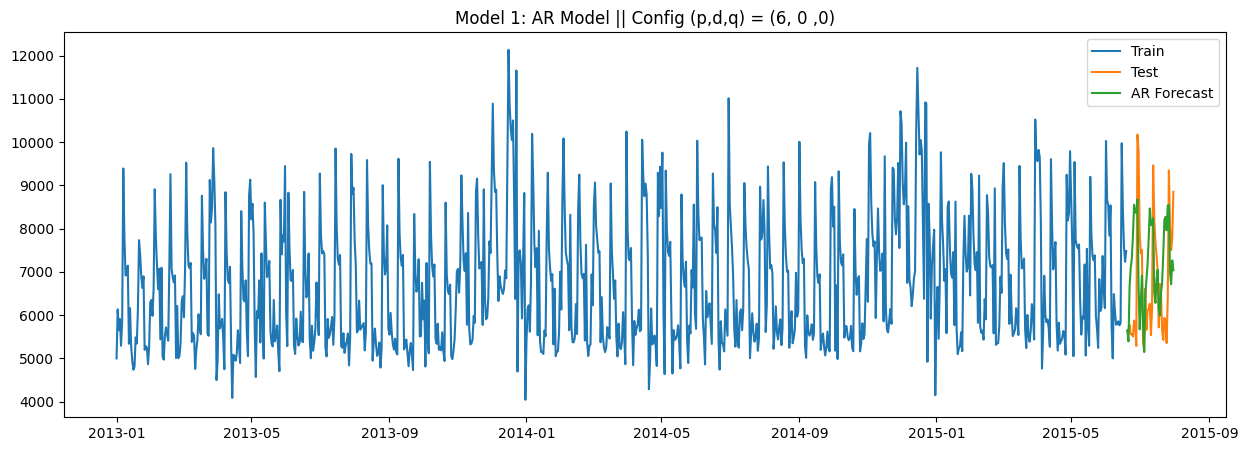

In [94]:
# Plotting the Train, Test and AR forecasts

plt.figure(figsize=(15,5))
plt.plot(df_train_data["Sales"][:len_train], label="Train")
plt.plot(df_train_data["Sales"][len_train:], label="Test")
plt.plot(y_hat_ar["ar_forecast"][df_test_values.index.min():], label="AR Forecast")
plt.legend(loc="best")
plt.title("Model 1: AR Model || Config (p,d,q) = (6, 0 ,0)")
plt.show()

In [95]:
# Calculating RMSE and Mape for Model 1: AR Model (6,0,0)

rmse = np.sqrt(mean_squared_error(df_test_values["Sales"], y_hat_ar["ar_forecast"][df_test_values.index.min():])).round(2)
mape = np.round(np.mean(np.abs(df_test_values["Sales"]-y_hat_ar["ar_forecast"][df_test_values.index.min():])/df_test_values["Sales"])*100,2)

results = pd.DataFrame({"Method":["AR Method"], "RMSE": [rmse],"MAPE": [mape] })
results = results[["Method", "RMSE", "MAPE"]]

# Displaying the "results" dataframe
results

Method     RMSE   MAPE
0  AR Method  1653.11  21.71

### Model 2: MA Model (Moving Average)  || Config (p,d,q) = (0, 0 ,1)

In [96]:
# Syntax ARIMA(p,d,q)

# Using q = 1

model_MA = sm.tsa.arima.ARIMA(df_sales_diff, order=(0, 0, 1))
model_MA_fit = model_MA.fit()
print(model_MA_fit.params)

const     4.095015e+00
ma.L1    -4.536726e-01
sigma2    1.909392e+06
dtype: float64


In [97]:
# Retrieving the series

y_hat_ma = df_sales_diff.copy()

y_hat_ma["mavg_forecast_diff"] = model_MA_fit.predict(df_sales_diff.index.min(), df_sales_diff.index.max())

y_hat_ma["mavg_forecast"] = y_hat_ma["mavg_forecast_diff"].cumsum()

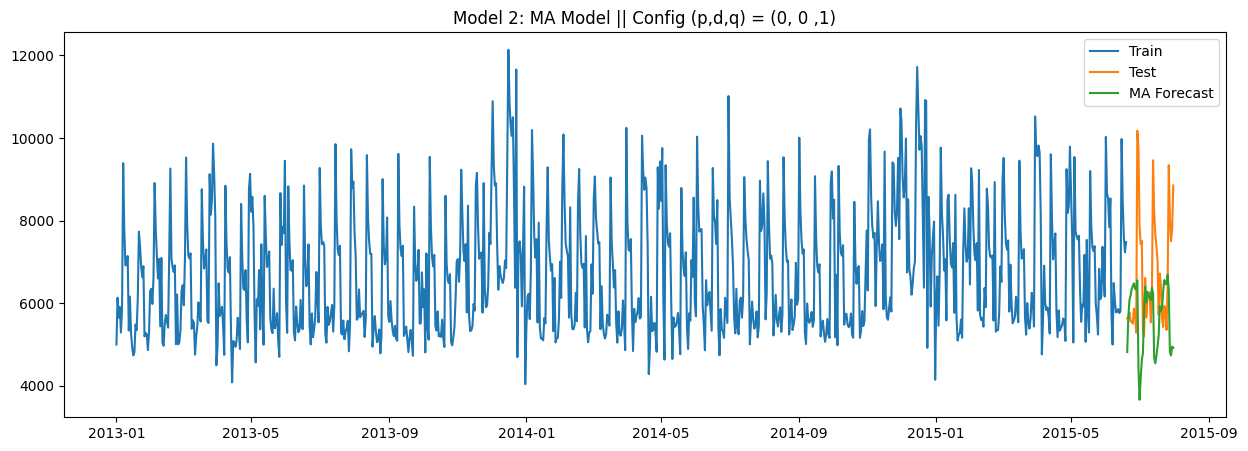

In [98]:
# Plotting the Train, Test and MA forecasts

plt.figure(figsize=(15,5))
plt.plot(df_train_data["Sales"][:len_train], label="Train")
plt.plot(df_train_data["Sales"][len_train:], label="Test")
plt.plot(y_hat_ma["mavg_forecast"][df_test_values.index.min():], label="MA Forecast")
plt.legend(loc="best")
plt.title("Model 2: MA Model || Config (p,d,q) = (0, 0 ,1)")
plt.show()

In [99]:
# Calculating RMSE and Mape for Model 2: MA Model (0,0,1)

rmse = np.sqrt(mean_squared_error(df_test_values["Sales"], y_hat_ma["mavg_forecast"][df_test_values.index.min():])).round(2)
mape = np.round(np.mean(np.abs(df_test_values["Sales"]-y_hat_ma["mavg_forecast"][df_test_values.index.min():])/df_test_values["Sales"])*100,2)

tempResults = pd.DataFrame({"Method":["MA Method"], "RMSE": [rmse],"MAPE": [mape] })
results = pd.concat([results, tempResults])
results = results[["Method", "RMSE", "MAPE"]]

# Displaying the "results" dataframe
results

Method     RMSE   MAPE
0  AR Method  1653.11  21.71
0  MA Method  2085.98  20.24

### Model 3: ARIMA Model  || Config (p,d,q) = (6, 0 ,1)

In [100]:
# Syntax ARIMA(p,d,q)

# Using p = 6 and q = 1

model_ARIMA = sm.tsa.arima.ARIMA(df_sales_diff, order=(6, 0, 1))
model_ARIMA_fit = model_ARIMA.fit()
print(model_ARIMA_fit.params)

const     4.094705e+00
ar.L1    -6.624476e-01
ar.L2    -3.123240e-01
ar.L3    -9.588177e-02
ar.L4    -5.865175e-02
ar.L5    -2.955809e-01
ar.L6    -4.096348e-01
ma.L1     2.661810e-01
sigma2    1.536157e+06
dtype: float64


In [101]:
# Retrieving the series

y_hat_arima = df_sales_diff.copy()

y_hat_arima["arima_forecast_diff"] = model_ARIMA_fit.predict(df_sales_diff.index.min(), df_sales_diff.index.max())

y_hat_arima["arima_forecast"] = y_hat_arima["arima_forecast_diff"].cumsum()

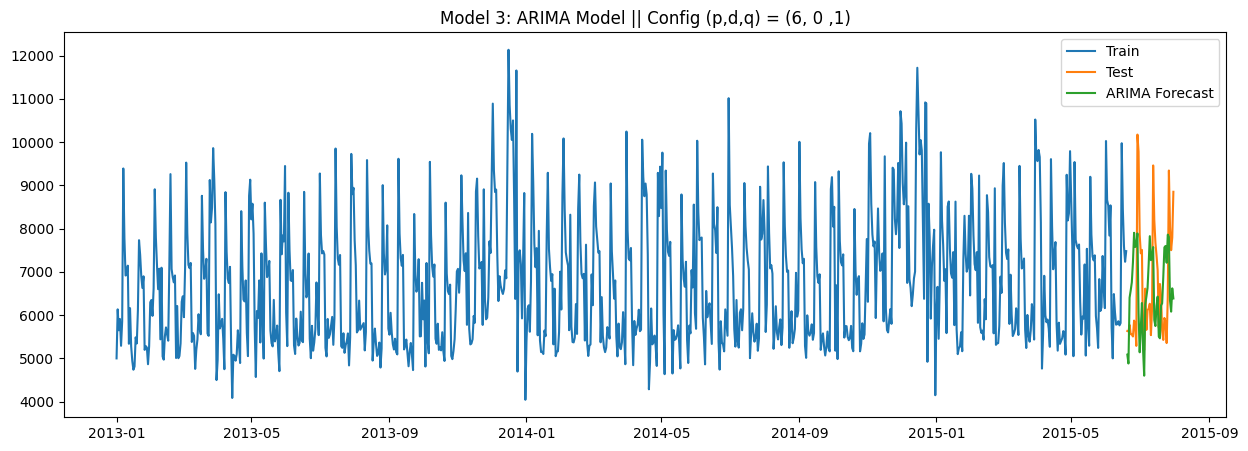

In [102]:
# Plotting the Train, Test and ARIMA forecasts

plt.figure(figsize=(15,5))
plt.plot(df_train_data["Sales"][:len_train], label="Train")
plt.plot(df_train_data["Sales"][len_train:], label="Test")
plt.plot(y_hat_arima["arima_forecast"][df_test_values.index.min():], label="ARIMA Forecast")
plt.legend(loc="best")
plt.title("Model 3: ARIMA Model || Config (p,d,q) = (6, 0 ,1)")
plt.show()

In [103]:
# Calculating RMSE and Mape for Model 3: ARIMA Model (6,0,1)

rmse = np.sqrt(mean_squared_error(df_test_values["Sales"], y_hat_arima["arima_forecast"][df_test_values.index.min():])).round(2)
mape = np.round(np.mean(np.abs(df_test_values["Sales"]-y_hat_arima["arima_forecast"][df_test_values.index.min():])/df_test_values["Sales"])*100,2)

tempResults = pd.DataFrame({"Method":["ARIMA Method"], "RMSE": [rmse],"MAPE": [mape] })
results = pd.concat([results, tempResults])
results = results[["Method", "RMSE", "MAPE"]]

# Displaying the "results" dataframe
results

Method     RMSE   MAPE
0     AR Method  1653.11  21.71
0     MA Method  2085.98  20.24
0  ARIMA Method  1576.56  20.47

### Model 4: SARIMA Model  || Config (p,d,q, s) = (6, 0 ,1, 12)

In [104]:
# Since we have yearly data, we will take the "s" parameter as 12

model_SARIMA = SARIMAX(df_sales_diff, order=(6,0,1), seasonal_order=(6,0,1,12))
model_SARIMA_fit = model_SARIMA.fit()
print(model_SARIMA_fit.params)

ar.L1      -5.568528e-01
ar.L2      -1.831577e-01
ar.L3      -1.622775e-02
ar.L4      -2.146605e-02
ar.L5      -2.559388e-01
ar.L6      -3.848788e-01
ma.L1       1.439908e-01
ar.S.L12   -6.687808e-01
ar.S.L24   -1.730682e-01
ar.S.L36   -7.015455e-02
ar.S.L48    1.384951e-02
ar.S.L60   -5.726306e-03
ar.S.L72   -1.320845e-01
ma.S.L12    5.671186e-01
sigma2      1.536067e+06
dtype: float64


In [105]:
# Retrieving the series

y_hat_sarima = df_sales_diff.copy()

y_hat_sarima["sarima_forecast_diff"] = model_SARIMA_fit.predict(df_sales_diff.index.min(), df_sales_diff.index.max())

y_hat_sarima["sarima_forecast"] = y_hat_sarima["sarima_forecast_diff"].cumsum()

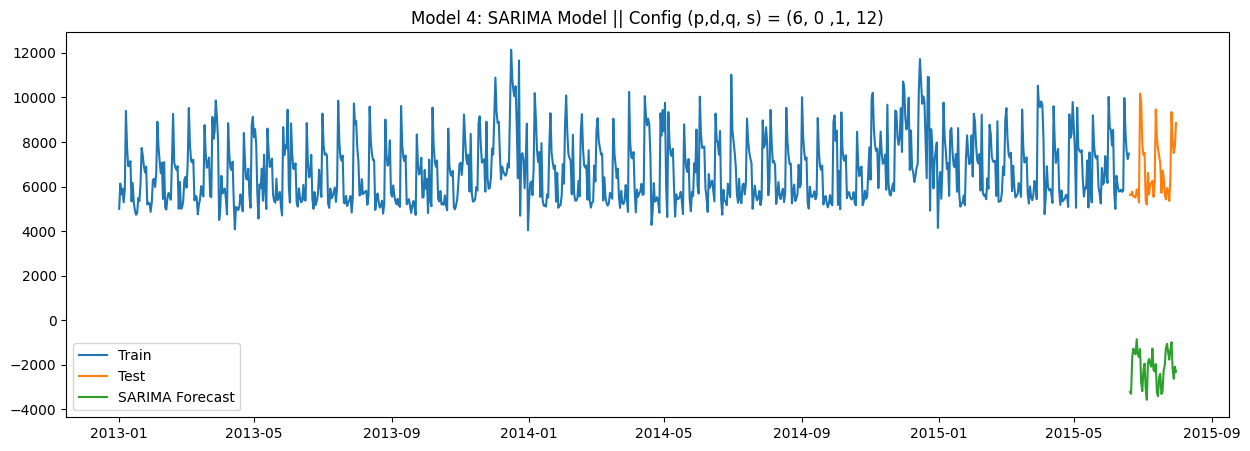

In [106]:
# Plotting the Train, Test and SARIMA forecasts

plt.figure(figsize=(15,5))
plt.plot(df_train_data["Sales"][:len_train], label="Train")
plt.plot(df_train_data["Sales"][len_train:], label="Test")
plt.plot(y_hat_sarima["sarima_forecast"][df_test_values.index.min():], label="SARIMA Forecast")
plt.legend(loc="best")
plt.title("Model 4: SARIMA Model || Config (p,d,q, s) = (6, 0 ,1, 12)")
plt.show()

In [107]:
# Calculating RMSE and Mape for Model 4: SARIMA Model (6,0,1,12)

rmse = np.sqrt(mean_squared_error(df_test_values["Sales"], y_hat_sarima["sarima_forecast"][df_test_values.index.min():])).round(2)
mape = np.round(np.mean(np.abs(df_test_values["Sales"]-y_hat_sarima["sarima_forecast"][df_test_values.index.min():])/df_test_values["Sales"])*100,2)

tempResults = pd.DataFrame({"Method":["SARIMA Method"], "RMSE": [rmse],"MAPE": [mape] })
results = pd.concat([results, tempResults])
results = results[["Method", "RMSE", "MAPE"]]

# Displaying the "results" dataframe
results

Method     RMSE    MAPE
0      AR Method  1653.11   21.71
0      MA Method  2085.98   20.24
0   ARIMA Method  1576.56   20.47
0  SARIMA Method  8963.19  132.72

### Model 5: VAR Model

In [108]:
# VAR Model

exog = df_train_values[["Promo", "Assortment_b", "Assortment_c", "StoreType_b","StoreType_c", "StoreType_d",
                        "StateHoliday_a","StateHoliday_b", "StateHoliday_c"]]
endog = df_train_values[["Sales", "Customers"]]
var_model = sm.tsa.VAR(endog,exog)
res=var_model.select_order(maxlags=15)

print(res.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        20.42       20.53   7.371e+08       20.46
1        20.15       20.28   5.642e+08       20.20
2        20.15       20.31   5.660e+08       20.21
3        20.14       20.31   5.565e+08       20.20
4        20.13       20.33   5.550e+08       20.21
5        20.09       20.31   5.315e+08       20.17
6        19.96       20.20   4.682e+08       20.06
7        19.94       20.20   4.580e+08       20.04
8        19.92       20.20   4.483e+08       20.03
9        19.88       20.19   4.321e+08       20.00
10       19.80       20.13   3.980e+08       19.93
11       19.72       20.07   3.679e+08       19.86
12       19.71       20.08   3.631e+08       19.85
13       19.70       20.09   3.580e+08       19.84
14       19.67       20.08   3.477e+08       19.82
15      19.62*      20.05*  3.326e+08*      19.79*
-------------------------------

In [109]:
# Fitting the VAR Model at Lag 15 as it"s the lowest

var_model_fit = var_model.fit(15)
var_model_fit.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 15, Jun, 2025
Time:                     11:01:59
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    20.0548
Nobs:                     885.000    HQIC:                   19.7876
Log likelihood:          -11114.4    FPE:                3.32565e+08
AIC:                      19.6222    Det(Omega_mle):     3.04424e+08
--------------------------------------------------------------------
Results for equation Sales
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const               4301.562062      3235.913492            1.329           0.184
Promo                  1.580446         0.100644           15.703           0.000
Assortment_b       -5588.356625      1743.918749        

#### Cointegration Test

In [110]:
# Creating a UDF for checking cointegration using "Johansen Test"
def cointegration_test(df, lag):

    alpha = 0.05
    out = coint_johansen(df, -1, lag)
    d = {"0.90": 0, "0.95": 1, "0.99": 2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]

    # Print summary header
    print("Name   ::  Test Stat > C(95%)    =>   Significance  ")
    print("--" * 10)

    # Print results for each column
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(f"{col.ljust(6)} :: {round(trace, 2):>9} > {cvt:8}  =>  {trace > cvt}")

In [111]:
# Performing Johansen Test with Lag = 15

cointegration_test(df_train_values[["Sales","Customers"]],15)

rank_result=select_coint_rank(df_train_values[["Sales","Customers"]],-1,15)

Name   ::  Test Stat > C(95%)    =>   Significance  
--------------------
Sales  ::     48.82 >  12.3212  =>  True
Customers ::      0.23 >   4.1296  =>  False


In [112]:
print(rank_result.rank)

1


#### Inferences:

- Rank = 1 suggests that the time series are co-integrated
- Hence, we can build a VAR/ VARMAX model

In [113]:
# Calculation of the lag order

lag_order = var_model_fit.k_ar
print(lag_order)

forecast_input = df_train_values[["Sales","Customers"]].values[-lag_order:]
forecast_input

15


array([[8537.32999088,  848.07201459],
       [5723.28028933,  623.44575045],
       [4998.6       ,  810.44      ],
       [6485.5907441 ,  721.90290381],
       [6061.50634058,  680.77626812],
       [5778.22513562,  656.67359855],
       [5790.98280543,  665.95565611],
       [5857.32217195,  665.58371041],
       [5762.29837251,  616.41048825],
       [5815.36      ,  902.12      ],
       [9974.74042951,  900.57236228],
       [8445.26007326,  809.41117216],
       [7594.44585987,  754.71610555],
       [7232.86830154,  731.60853769],
       [7478.71597096,  759.45644283]])

In [114]:
# Generating the forecasts

exog_test = df_test_values[["Promo", "Assortment_b", "Assortment_c", "StoreType_b","StoreType_c", "StoreType_d",
                            "StateHoliday_a","StateHoliday_b", "StateHoliday_c"]].astype(float)

fc = var_model_fit.forecast(y=forecast_input, steps=42, exog_future=exog_test)


var_forecast = pd.DataFrame(fc, index=df_test_values.index, columns=["Sales","Customers"])
var_forecast.head()

Sales   Customers
Date                               
2015-06-20  5644.049154  627.056150
2015-06-21  5432.785209  892.699321
2015-06-22  6550.034238  753.018624
2015-06-23  5720.865771  680.924464
2015-06-24  5509.777464  651.305609

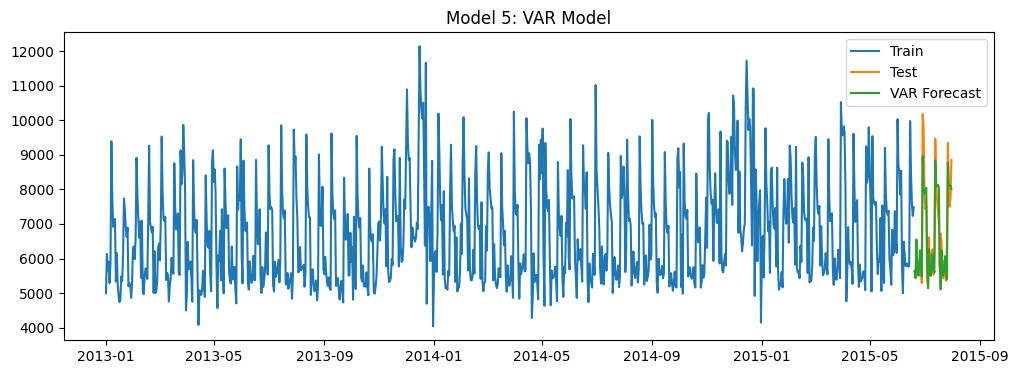

In [115]:
# Plotting the Train, Test and VAR forecasts

plt.figure(figsize=(12,4))
plt.plot(df_train_values["Sales"], label="Train")
plt.plot(df_test_values["Sales"], label="Test")
plt.plot(var_forecast["Sales"][df_test_values.index.min():], label="VAR Forecast")
plt.legend(loc="best")
plt.title("Model 5: VAR Model")
plt.show()

In [116]:
# Calculating RMSE and Mape for Model 5: VAR Model

rmse = np.sqrt(mean_squared_error(df_test_values["Sales"], var_forecast["Sales"][df_test_values.index.min():])).round(2)
mape = np.round(np.mean(np.abs(df_test_values["Sales"]-var_forecast["Sales"][df_test_values.index.min():])/df_test_values["Sales"])*100,2)

tempResults = pd.DataFrame({"Method":["VAR Method"], "RMSE": [rmse],"MAPE": [mape] })
results = pd.concat([results, tempResults])
results = results[["Method", "RMSE", "MAPE"]]

# Displaying the "results" dataframe
results

Method     RMSE    MAPE
0      AR Method  1653.11   21.71
0      MA Method  2085.98   20.24
0   ARIMA Method  1576.56   20.47
0  SARIMA Method  8963.19  132.72
0     VAR Method   602.41    6.18

### Model 6: VARMAX Model

In [117]:
# Using p = 7 and q = 0

exog = df_train_values[["Promo", "Assortment_b", "Assortment_c", "StoreType_b","StoreType_c", "StoreType_d",
                        "StateHoliday_a","StateHoliday_b", "StateHoliday_c"]]

model_VARMAX = sm.tsa.VARMAX(df_train_values[["Sales", "Customers"]], order=(7,0), trend = "n", exog = exog)
res_VARMAX = model_VARMAX.fit(maxiter = 1000, disp=False)

res_VARMAX.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             Statespace Model Results                             
==================================================================================
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  900
Model:                            VARX(7)   Log Likelihood              -12139.177
Date:                    Sun, 15 Jun 2025   AIC                          24376.354
Time:                            11:07:22   BIC                          24611.671
Sample:                        01-01-2013   HQIC                         24466.247
                             - 06-19-2015                                         
Covariance Type:                      opg                                         
===================================================================================
Ljung-Box (L1) (Q):            56.21, 7.81   Jarque-Bera (JB):      620.28, 4864.98
Prob(Q):                        0.00, 0.01   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.88, 1.16   Skew:                       0.91, 0.62
Prob(H) (two-sided):            0.00, 0.19   Kurtosis:                  6.64, 14.32
                               Results for equation Sales                              
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
L1.Sales                0.0505      0.024      2.134      0.033       0.004       0.097
L1.Customers            2.3616      0.176     13.427      0.000       2.017       2.706
L2.Sales                0.0686      0.029      2.391      0.017       0.012       0.125
L2.Customers           -0.3346      0.211     -1.586      0.113      -0.748       0.079
L3.Sales               -0.0058      0.028     -0.206      0.836      -0.061       0.049
L3.Customers           -0.5017      0.222     -2.262      0.024      -0.936      -0.067
L4.Sales               -0.1117      0.032     -3.540      0.000      -0.174      -0.050
L4.Customers            0.5407      0.214      2.533      0.011       0.122       0.959
L5.Sales               -0.0121      0.035     -0.342      0.732      -0.081       0.057
L5.Customers            0.6388      0.194      3.294      0.001       0.259       1.019
L6.Sales               -0.0972      0.040     -2.440      0.015      -0.175      -0.019
L6.Customers            0.4552      0.221      2.062      0.039       0.022       0.888
L7.Sales                0.2245      0.044      5.068      0.000       0.138       0.311
L7.Customers           -0.6682      0.467     -1.432      0.152      -1.583       0.247
beta.Promo              2.0326      0.076     26.639      0.000       1.883       2.182
beta.Assortment_b   -4422.8662   1795.954     -2.463      0.014   -7942.870    -902.862
beta.Assortment_c    1351.3641    444.099      3.043      0.002     480.946    2221.783
beta.StoreType_b     8301.5776   1030.499      8.056      0.000    6281.837    1.03e+04
beta.StoreType_c     9503.1600   1880.052      5.055      0.000    5818.326    1.32e+04
beta.StoreType_d     3008.2617   1138.865      2.641      0.008     776.126    5240.397
beta.StateHoliday_a  -234.3673    217.243     -1.079      0.281    -660.155     191.420
beta.StateHoliday_b   302.2689    463.092      0.653      0.514    -605.374    1209.912
beta.StateHoliday_c  -337.7080    589.843     -0.573      0.567   -1493.780     818.364
                             Results for equation Customers                            
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
L1.Sales                0.0064      0.003      2.125     

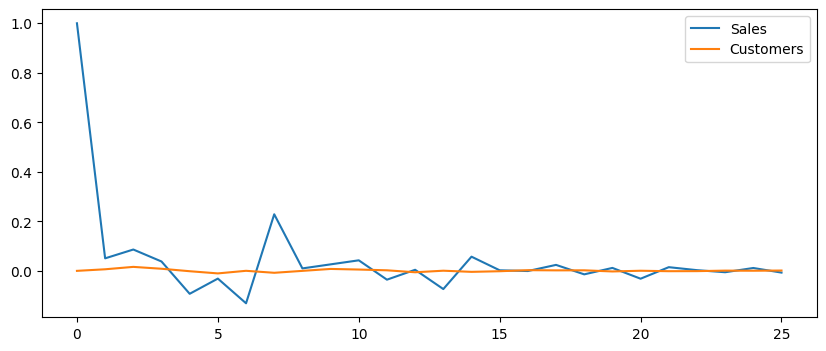

In [118]:
# Impulse response factor

irf = res_VARMAX.impulse_responses(steps=25, orthogonalized=False)
irf.plot(figsize=(10,4))
plt.show()

In [119]:
# Training the model

start_index = df_test_values.index.min()

end_index = df_test_values.index.max()



predictions = model_VARMAX.fit().predict(start = start_index, end = end_index,
                                         exog = df_test_values[["Promo", "Assortment_b", "Assortment_c", "StoreType_b","StoreType_c", "StoreType_d",
                                                                "StateHoliday_a","StateHoliday_b", "StateHoliday_c"]])

In [120]:
# Checking the shape of the predictions

predictions.shape

(42, 2)

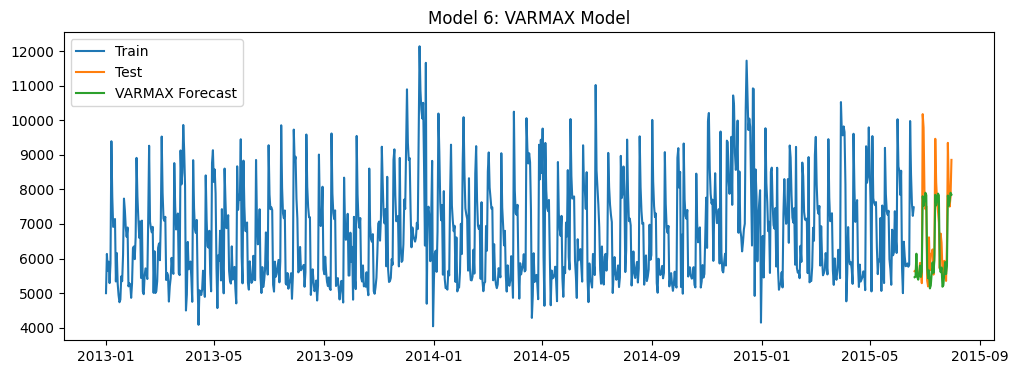

In [121]:
# Plotting the Train, Test and VARMAX forecasts

plt.figure(figsize=(12,4))
plt.plot(df_train_values["Sales"], label="Train")
plt.plot(df_test_values["Sales"], label="Test")
plt.plot(predictions["Sales"], label="VARMAX Forecast")
plt.legend(loc="best")
plt.title("Model 6: VARMAX Model")
plt.show()

In [122]:
# Calculating RMSE and Mape for Model 6: VARMAX Model

rmse = np.sqrt(mean_squared_error(df_test_values["Sales"], predictions["Sales"][df_test_values.index.min():])).round(2)
mape = np.round(np.mean(np.abs(df_test_values["Sales"]-predictions["Sales"][df_test_values.index.min():])/df_test_values["Sales"])*100,2)

tempResults = pd.DataFrame({"Method":["VARMAX Method"], "RMSE": [rmse],"MAPE": [mape] })
results = pd.concat([results, tempResults])
results = results[["Method", "RMSE", "MAPE"]]

# Displaying the "results" dataframe
results

Method     RMSE    MAPE
0      AR Method  1653.11   21.71
0      MA Method  2085.98   20.24
0   ARIMA Method  1576.56   20.47
0  SARIMA Method  8963.19  132.72
0     VAR Method   602.41    6.18
0  VARMAX Method   762.36    7.15

### Summary of all the models

In [123]:
# Displaying the "results" dataframe soted by the "MAPE" column

results_sorted = results.sort_values(by=["MAPE"], ascending = True)

results_sorted

Method     RMSE    MAPE
0     VAR Method   602.41    6.18
0  VARMAX Method   762.36    7.15
0      MA Method  2085.98   20.24
0   ARIMA Method  1576.56   20.47
0      AR Method  1653.11   21.71
0  SARIMA Method  8963.19  132.72

#### *Inference*:

- VAR (Vector Auto-Regressive) model outperformed other models, achieving the lowest RMSE and MAPE scores.

- RMSE for VAR Model: 602.41

- MAPE for VAR Model: 6.18

In [124]:
# Creating a function for visualization for the "Test" and "Forecasted" values using VAR Model

def forecast_series_visualize(series,forecasted_series,c,model):
    fig = plt.figure(figsize=(20, 3))
    series.plot(label="Actual")
    forecasted_series.plot(label="Forecasted")
    plt.xlabel("Date")
    plt.ylabel(c)
    plt.legend(loc="best")
    plt.title("{} model For {}".format(model,c))
    plt.show()

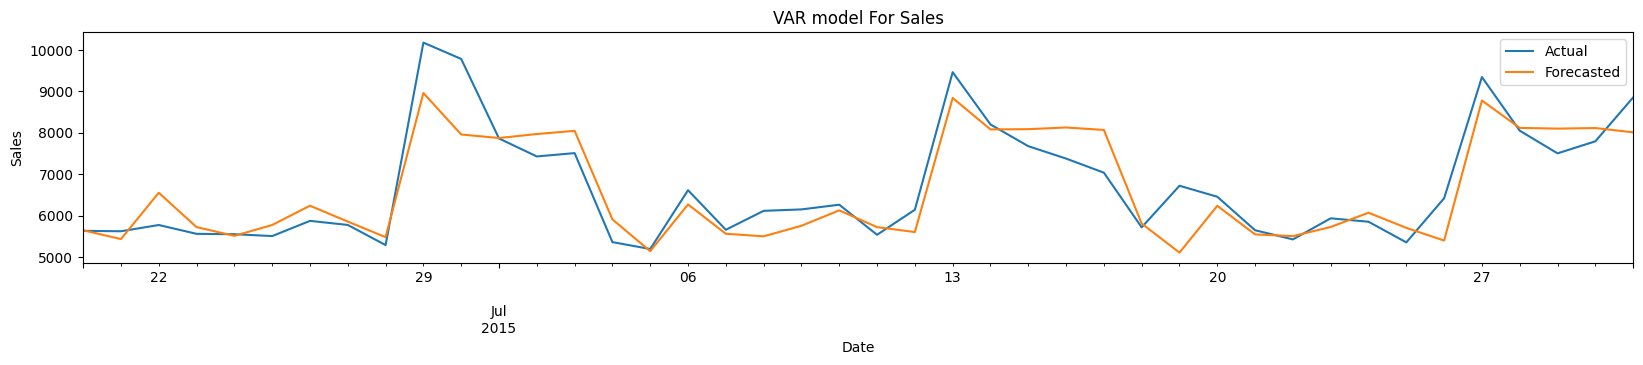

In [125]:
# Plotting the forecasts of VAR Model:

forecast_series_visualize(df_test_values["Sales"], var_forecast["Sales"], "Sales", "VAR")

## Step 7: Predicting for the next 6 weeks (1st Aug 2015 to 11th September 2015)

In [126]:
# Creating new dates from 1st Aug 2015 to 11th September 2015 (42 Days or 6 Weeks)

dates_range = pd.date_range(start="2015-08-01", end="2015-09-11")
new_dates = pd.DataFrame({"Date":dates_range, "Empty Column":np.nan})
new_dates = new_dates.set_index("Date")

In [127]:
# Displaying "new_dates" dataframe

new_dates.head()

Empty Column
Date                    
2015-08-01           NaN
2015-08-02           NaN
2015-08-03           NaN
2015-08-04           NaN
2015-08-05           NaN

In [128]:
# Checking the shape of the "new_dates" dataframe

new_dates.shape

(42, 1)

In [130]:
# Selecting 042 as the length of our new "Train" dataset as we're using the entire dataset as "Train" data

new_len_train = 942

df_newdates_train = df_train_data[:new_len_train]

In [131]:
# Calculating values for model VAR

exog = df_newdates_train[["Promo", "Assortment_b", "Assortment_c", "StoreType_b","StoreType_c", "StoreType_d",
                          "StateHoliday_a","StateHoliday_b", "StateHoliday_c"]].astype(float)
endog = df_newdates_train[["Sales", "Customers"]].astype(float)

var_new_model = sm.tsa.VAR(endog,exog)

res_new_var = var_new_model.select_order(maxlags=15)

print(res_new_var.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        20.43       20.54   7.465e+08       20.47
1        20.17       20.29   5.749e+08       20.22
2        20.17       20.32   5.757e+08       20.23
3        20.15       20.32   5.660e+08       20.22
4        20.15       20.33   5.619e+08       20.22
5        20.10       20.31   5.357e+08       20.18
6        19.99       20.22   4.825e+08       20.08
7        19.98       20.23   4.742e+08       20.07
8        19.96       20.23   4.663e+08       20.06
9        19.92       20.21   4.468e+08       20.03
10       19.83       20.14   4.081e+08       19.95
11       19.74       20.07   3.743e+08       19.87
12       19.72       20.07   3.665e+08       19.85
13       19.70       20.08   3.600e+08       19.84
14       19.67       20.06   3.476e+08       19.82
15      19.62*      20.04*  3.324e+08*      19.78*
-------------------------------

In [132]:
# Fitting the model and using Lag 15

var_new_modelfit = var_new_model.fit(15)

var_new_modelfit.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 15, Jun, 2025
Time:                     11:12:39
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    20.0388
Nobs:                     927.000    HQIC:                   19.7809
Log likelihood:          -11645.4    FPE:                3.32420e+08
AIC:                      19.6218    Det(Omega_mle):     3.05488e+08
--------------------------------------------------------------------
Results for equation Sales
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const               3967.380545      3197.452950            1.241           0.215
Promo                  1.598396         0.098852           16.170           0.000
Assortment_b       -5665.855796      1713.272347        

In [133]:
# Taking the lag order from the model

lag_order = var_new_modelfit.k_ar

print(lag_order)

forecast_input = df_newdates_train[["Sales","Customers"]].values[-lag_order:]

forecast_input

15


array([[7034.30601093,  722.11020036],
       [5715.36832579,  612.96470588],
       [6719.52      ,  999.32      ],
       [6453.58598726,  715.27479527],
       [5645.15927602,  646.30045249],
       [5424.39457014,  621.03800905],
       [5933.15851449,  666.62047101],
       [5850.71622847,  657.65457842],
       [5352.43812105,  566.91056911],
       [6417.68      ,  987.28      ],
       [9343.62511542,  835.63434903],
       [8048.98907104,  764.46903461],
       [7501.45677889,  722.15741583],
       [7791.86648501,  751.1044505 ],
       [8851.50505051,  835.05601469]])

In [134]:
# Generating the forecasts

exog_test = df_test_values[["Promo", "Assortment_b", "Assortment_c", "StoreType_b","StoreType_c", "StoreType_d",
                            "StateHoliday_a","StateHoliday_b", "StateHoliday_c"]].astype(float)

new_week_forecasts = var_new_modelfit.forecast(y = forecast_input, steps = 42, exog_future = exog_test)
var_newweeks_forecast = pd.DataFrame(new_week_forecasts, index = new_dates.index, columns = ["Sales","Customers"])

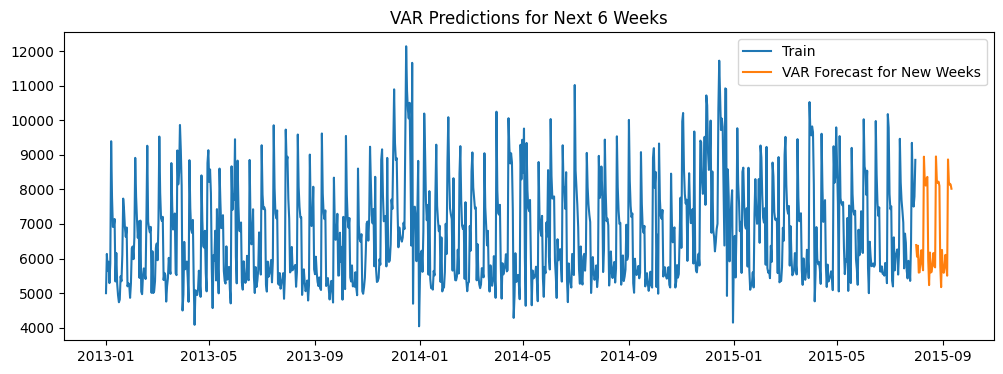

In [135]:
# Plotting the Train and "var_newweeks_forecast"

plt.figure(figsize=(12,4))
plt.plot(df_newdates_train["Sales"], label="Train")
plt.plot(var_newweeks_forecast["Sales"][new_dates.index.min():], label="VAR Forecast for New Weeks")
plt.legend(loc="best")


plt.title("VAR Predictions for Next 6 Weeks")
plt.show()

In [136]:
# Actual forecasts for the next 6 weeks from 1st Aug 2015 to 11th September 2015 (42 Days or 6 Weeks)

var_newweeks_forecast.head(10)

Sales   Customers
Date                               
2015-08-01  6389.492595  682.056762
2015-08-02  6052.210034  941.843738
2015-08-03  6369.391905  726.565347
2015-08-04  5592.722924  659.313728
2015-08-05  5602.120049  647.833415
2015-08-06  5981.755866  684.418948
2015-08-07  6239.817786  713.443105
2015-08-08  5849.442689  643.612353
2015-08-09  5659.720603  872.406820
2015-08-10  8943.854161  850.620215

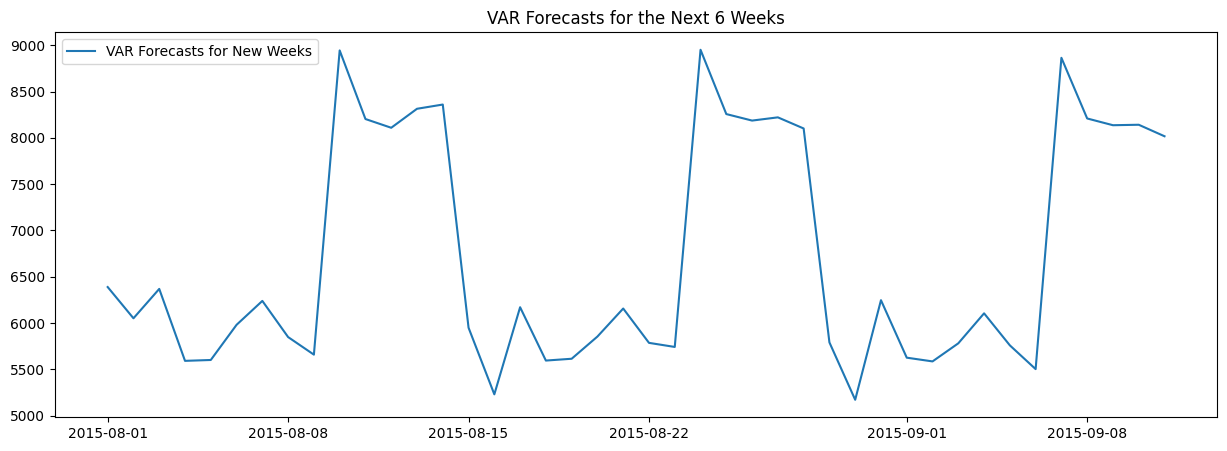

In [137]:
# Plotting the predictions for the next 6 weeks from 1st Aug 2015 to 11th September 2015 (42 Days or 6 Weeks)

plt.figure(figsize=(15, 5))
plt.plot(var_newweeks_forecast["Sales"][new_dates.index.min():], label="VAR Forecasts for New Weeks")
plt.legend(loc="best")
plt.title("VAR Forecasts for the Next 6 Weeks")
plt.show()

## Step 8: Conclusion & Recommendations

### Conclusion

- We experimented with various time series models, including **AR, MA, ARIMA, SARIMA, VAR, and VARMAX**.  
- The **VAR (Vector Auto-Regressive) model** was identified as the best, based on its lowest RMSE and MAPE scores.  
- **RMSE for VAR Model:** 602.41  
- **MAPE for VAR Model:** 6.18  
- Using the VAR model, we forecasted **sales for the next six weeks**, covering **August 1, 2015, to September 11, 2015** (42 days).

### Recommendations

- **Expand the presence of store type "B"** since these stores consistently achieve higher sales compared to other types.  
- **Broaden promotional activities** to more stores, leveraging their proven impact on boosting sales.  
- **Take advantage of seasonal trends** by intensifying promotions during holidays to maximize revenue potential.